In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from CGCNN_MT.predict import main as predict_main
import sys
sys.path.append("./CGCNN_MT")
# import matplotlib; matplotlib.use('Agg')
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## ML results

In [2]:
model_root_dir = "./ML/models"
model_root_dir = Path(model_root_dir)

cls_tasks = ["SSD", "WS24"]
reg_tasks = ["TSD"]
all_metrics = {}
for task_set, tp in zip([cls_tasks, reg_tasks], ["cls", "reg"]):
    dfs = []
    for task in task_set:
        model_dir = model_root_dir / task/ "RAC_and_zeo_features_with_id_prop"
        for subdir in model_dir.iterdir():
            if not subdir.is_dir():
                continue
            model_metrics_file = subdir / "model_metrics.csv"
            df_metrics = pd.read_csv(model_metrics_file, index_col=0)
            keep_cols = [col for col in df_metrics.columns if "tr_" not in col and "val_" not in col]
            df_metrics = df_metrics.loc[["mean"], keep_cols].copy()
            df_metrics = df_metrics[~df_metrics["model_name"].isin(["XGBClassifier", "XGBRegressor", "LogisticRegression", "LinearRegression"])]
            df_metrics.insert(0, "Task", "_".join([task, subdir.name]).replace("_label", "").replace("_Label", ""))

            dfs.append(df_metrics)
            if tp == "cls":
                df_metrics.sort_values(by=["te_AUC"], inplace=True, ascending=False)
            else:
                df_metrics.sort_values(by=["te_MAE"], inplace=True)
            df_metrics.columns = [col.replace("te_", "") for col in df_metrics.columns]
            all_metrics[task + "_" + subdir.name] = df_metrics.to_dict("records")[0]

    # df_metrics_all = pd.concat(dfs)
    # df_metrics_all.index.name = "epoch"
    # df_metrics_all.reset_index(inplace=True)
    # df_metrics_all.sort_values(by=["Task", "model_name", "epoch"], inplace=True)
    # df_metrics_all.to_csv(model_root_dir/f"model_metrics_{tp}.csv", index=False)

keep_cols = ["Task", "R2", "MAE", "ACC", "BACC", "AUC", "model_name"]
df_ml_our = pd.DataFrame(all_metrics).T.copy()
df_ml_our = df_ml_our[keep_cols]
df_ml_our.insert(0, "Model", "Baseline")
df_ml_our = df_ml_our.rename(columns={'AUC': 'AUROC', "model_name": "Algorithm"}).reset_index(drop=True)
df_ml_our["Algorithm"] = df_ml_our["Algorithm"].map(lambda x: "RF" if "RandomForest" in x else "GP")
df_ml_our.set_index(["Task", "Model"], inplace=True)
df_ml_our

R2               MAE     ACC    BACC  \
Task         Model                                                           
SSD          Baseline                NaN               NaN  0.7615  0.7261   
WS24_water4  Baseline                NaN               NaN  0.6393  0.5154   
WS24_boiling Baseline                NaN               NaN  0.7308  0.7308   
WS24_acid    Baseline                NaN               NaN  0.8056  0.8056   
WS24_water   Baseline                NaN               NaN  0.7123  0.6868   
WS24_base    Baseline                NaN               NaN  0.7083  0.7083   
TSD          Baseline  0.465726060341605  45.4287514910119     NaN     NaN   

                        AUROC Algorithm  
Task         Model                       
SSD          Baseline  0.8342        RF  
WS24_water4  Baseline  0.8479        RF  
WS24_boiling Baseline  0.6805        RF  
WS24_acid    Baseline  0.9198        GP  
WS24_water   Baseline  0.7697        RF  
WS24_base    Baseline  0.7431        GP  
TSD          Baseline     NaN        RF

In [2]:
metrics_ref_dir = "./raw_data/WS24v2/models/metrics"
metrics_ref_dir = Path(metrics_ref_dir)
label2task_map = {
    "water_label": "WS24_water",
    "4_class_water_label": "WS24_water4",
    "acid_label": "WS24_acid",
    "base_label": "WS24_base",
    "boiling_label": "WS24_boiling",
}

saved_dir = Path("./CGCNN_MT/evaluation")

In [4]:
## ML results from Terrones et al. 2024(10.1021/jacs.4c05879)
all_metrics = []
# for d in [metrics_ours_dir, metrics_ref_dir]:
for d in [metrics_ref_dir]:
    for file in d.glob('*.txt'):
        label_name = file.stem.replace("mean_metrics_", "")
        with open(file, 'r') as f:
            lines = f.readlines()
        metrics = {}
        for line in lines:
            metric_name, metric_value = line.strip().split(": ")
            if "test" in metric_name and "mean" in metric_name:
                metric_value = float(metric_value)
                metric_name = metric_name.replace("-mean", "")
                metric_name = metric_name.replace("test_", "")
                # print(f"{label_name}: {metric_name}: {metric_value}")
                metrics.update({metric_name: metric_value})
        metrics.update({"Task": label2task_map[label_name], "Model": d.name})
    
        all_metrics.append(metrics)

group_map = {"metrics": "Reference"}
df_ml_terrones = pd.DataFrame(all_metrics)
df_ml_terrones.rename(columns={'acc': 'ACC', 'bal_acc': 'BACC', 'roc_auc': 'AUROC'}, inplace=True)
df_ml_terrones["Model"] = df_ml_terrones["Model"].apply(lambda x: group_map[x])
df_ml_terrones.set_index(["Task", "Model"], inplace=True)
df_ml_terrones.sort_index(level=0, inplace=True)
df_ml_terrones.drop(columns=["AP", "F1"], inplace=True)
df_ml_terrones["Algorithm"] = "RF"
df_ml_terrones

ACC      BACC     AUROC Algorithm
Task         Model                                            
WS24_acid    Reference  0.780556  0.780556  0.850772        RF
WS24_base    Reference  0.704000  0.703526  0.780769        RF
WS24_boiling Reference  0.648148  0.648901  0.693956        RF
WS24_water   Reference  0.768493  0.742705  0.828500        RF
WS24_water4  Reference  0.655251  0.512478  0.816146        RF

In [5]:
## ML results from Nandy et al. 2021(10.1021/jacs.1c07217)
df_ml_nandy = pd.DataFrame(
    [
        {   
            "Task": "TSD",
            "Model": "Reference",
            "R2": 0.46,
            "MAE": 44

        },
        {   
            "Task": "SSD",
            "Model": "Reference",
            "ACC": 0.76,
            "AUROC": 0.81,
        },
        

    ]
)
df_ml_nandy.set_index(["Task", "Model"], inplace=True)
df_ml_nandy["Algorithm"] = "GP"
df_ml_nandy

R2   MAE   ACC  AUROC Algorithm
Task Model                                       
TSD  Reference  0.46  44.0   NaN    NaN        GP
SSD  Reference   NaN   NaN  0.76   0.81        GP

In [6]:
df_metrics = pd.concat([df_ml_our, df_ml_nandy, df_ml_terrones])
df_metrics.sort_index(inplace=True)
for col in ["R2", "MAE", "ACC", "BACC", "AUROC"]:
    df_metrics[col] = df_metrics[col].apply(lambda x: round(float(x), 2))   


df_metrics = df_metrics.reset_index()
df_metrics["Task"] = df_metrics["Task"].apply(lambda x: str(x).strip())
df_metrics.set_index(["Task", "Model"], inplace=True)
index = []
for task in ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]:
    for model in ["Baseline", "Reference"]:
        index.append((task, model))
df_metrics = df_metrics.reindex(index=index)

df_metrics.to_excel(saved_dir/"ML_results_test.xlsx")

df_metrics

R2    MAE   ACC  BACC  AUROC Algorithm
Task         Model                                              
TSD          Baseline   0.47  45.43   NaN   NaN    NaN        RF
             Reference  0.46  44.00   NaN   NaN    NaN        GP
SSD          Baseline    NaN    NaN  0.76  0.73   0.83        RF
             Reference   NaN    NaN  0.76   NaN   0.81        GP
WS24_water   Baseline    NaN    NaN  0.71  0.69   0.77        RF
             Reference   NaN    NaN  0.77  0.74   0.83        RF
WS24_water4  Baseline    NaN    NaN  0.64  0.52   0.85        RF
             Reference   NaN    NaN  0.66  0.51   0.82        RF
WS24_acid    Baseline    NaN    NaN  0.81  0.81   0.92        GP
             Reference   NaN    NaN  0.78  0.78   0.85        RF
WS24_base    Baseline    NaN    NaN  0.71  0.71   0.74        GP
             Reference   NaN    NaN  0.70  0.70   0.78        RF
WS24_boiling Baseline    NaN    NaN  0.73  0.73   0.68        RF
             Reference   NaN    NaN  0.65  0.65   0.69        RF

## Single task CGCNN and CGCNN-MT results analysis

In [7]:
task2models = {'TSD': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/TSD_seed42_cgcnn_raw/version_29'},
 'SSD': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/SSD_seed42_cgcnn_raw/version_4'},
 'WS24_water': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_water_seed42_cgcnn_raw/version_29'},
 'WS24_water4': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_water4_seed42_cgcnn_raw/version_3'},
 'WS24_acid': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_acid_seed42_cgcnn_raw/version_47'},
 'WS24_base': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_base_seed42_cgcnn_raw/version_0'},
 'WS24_boiling': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/WS24_boiling_seed42_cgcnn_raw/version_7'},
 'TSD_SSD_WS24_all': {'Model': 'cgcnn_raw',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw/version_24'},
 'TSD_SSD_WS24_all_attn': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_43'}}

task_types:  ['regression']


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggrega

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
2024-08-20 18:28:26.052202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 18:28:26.122256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environmen

Predicting: |          | 0/? [00:00<?, ?it/s]

(40,) (40,)
TSD/external_test_R2Score: 0.4137, TSD/external_test_MeanAbsoluteError: 49.9903


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_seed42_cgcnn_raw@version_29/external_test_metrics.csv
task_types:  ['regression']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggrega

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/SSD_seed42_cgcnn_raw@version_4/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 272
extra_fea_len: 16
h_fea_len: 32
n_conv: 6
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha:

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 5
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 240
extra_fea_len: 16
h_fea_len: 80
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregati

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_water_seed42_cgcnn_raw@version_29/external_test_metrics.csv
task_types:  ['classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 48
extra_fea_len: 16
h_fea_len: 208
n_conv: 6
n_h: 6
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
d

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_water4_seed42_cgcnn_raw@version_3/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 208
extra_fea_len: 16
h_fea_len: 144
n_conv: 4
n_h: 4
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
d

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_acid_seed42_cgcnn_raw@version_47/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 160
extra_fea_len: 16
h_fea_len: 160
n_conv: 7
n_h: 8
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9

Metrics saved to CGCNN_MT/evaluation/WS24_base_seed42_cgcnn_raw@version_0/external_test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 2
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 32
extra_fea_len: 16
h_fea_len: 48
n_conv: 1
n_h: 7
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_al

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/WS24_boiling_seed42_cgcnn_raw@version_7/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 128
extra_fea_len: 16
h_f

Predicting: |          | 0/? [00:00<?, ?it/s]

(40,) (40,)
TSD/external_test_R2Score: 0.4378, TSD/external_test_MeanAbsoluteError: 51.1142


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting SSD...
prop_cols: ['ss_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_nam

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zhangsd/repos/MOFSNN/CGCNN_MT/module/module_utils.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: 

Predicting: |          | 0/? [00:00<?, ?it/s]

(40,) (40,)
TSD/external_test_R2Score: 0.4897, TSD/external_test_MeanAbsoluteError: 45.5857


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting SSD...
prop_cols: ['ss_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/external_test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: 

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/external_test_metrics.csv
task_types:  ['regression']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
a

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4335, TSD/test_MeanAbsoluteError: 45.3843


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_seed42_cgcnn_raw@version_29/test_metrics.csv
task_types:  ['regression']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 14
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 144
extra_fea_len: 16
h_fea_len: 288
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_l

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 272
extra_fea_len: 16
h_fea_len: 32
n_conv: 6
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregat

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/SSD_seed42_cgcnn_raw@version_4/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 272
extra_fea_len: 16
h_fea_len: 32
n_conv: 6
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 5
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 240
extra_fea_len: 16
h_fea_len: 80
n_conv: 7
n_h: 2
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregati

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/WS24_water_seed42_cgcnn_raw@version_29/test_metrics.csv
task_types:  ['classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 48
extra_fea_len: 16
h_fea_len: 208
n_conv: 6
n_h: 6
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha:

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/WS24_water4_seed42_cgcnn_raw@version_3/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 20
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 208
extra_fea_len: 16
h_fea_len: 144
n_conv: 4
n_h: 4
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha:

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/WS24_acid_seed42_cgcnn_raw@version_47/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 160
extra_fea_len: 16
h_fea_len: 160
n_conv: 7
n_h: 8
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 160
extra_fea_len: 16
h_fea_len: 160
n_conv: 7
n_h: 8
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
data_dir: ./CGCNN_MT/data
dl_sampler: random
model_cfg: cgcnn_raw
task_att_type: self
loss_aggregat

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If you

Metrics saved to CGCNN_MT/evaluation/WS24_base_seed42_cgcnn_raw@version_0/test_metrics.csv
task_types:  ['classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 2
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 32
extra_fea_len: 16
h_fea_len: 48
n_conv: 1
n_h: 7
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/WS24_boiling_seed42_cgcnn_raw@version_7/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_raw
atom_fea_len: 128
extra_fea_len: 16
h_fea_len: 1

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.3470, TSD/test_MeanAbsoluteError: 48.0305


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: False
lr_mult: 12
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: cgcnn_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_cgcnn_raw@version_24/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4484, TSD/test_MeanAbsoluteError: 45.1970


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 144
extra_fea_len: 28
h_fea_len: 144
n_conv: 4
n_h: 8
att_S: 64
dropout_prob: 0.55
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
task_att_type: self
data_dir: ./CGCNN_MT/data
dl_sampler: random
loss_aggregation: fixed_weight_sum


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv


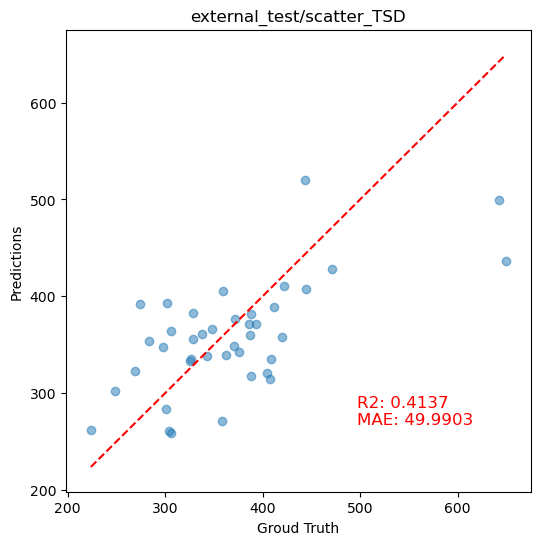

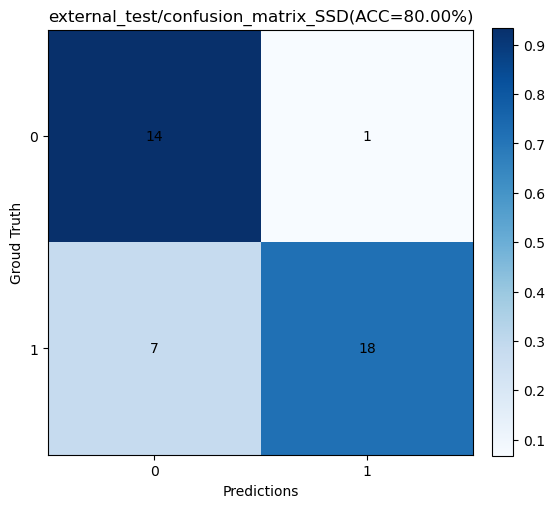

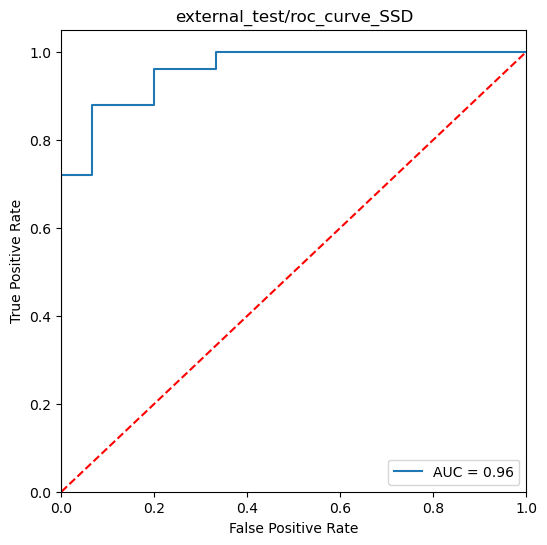

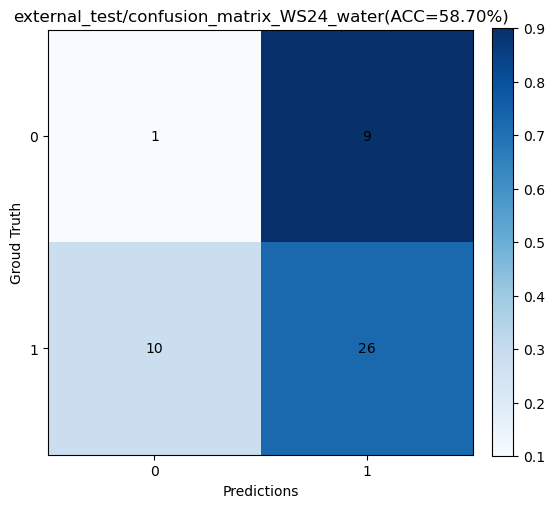

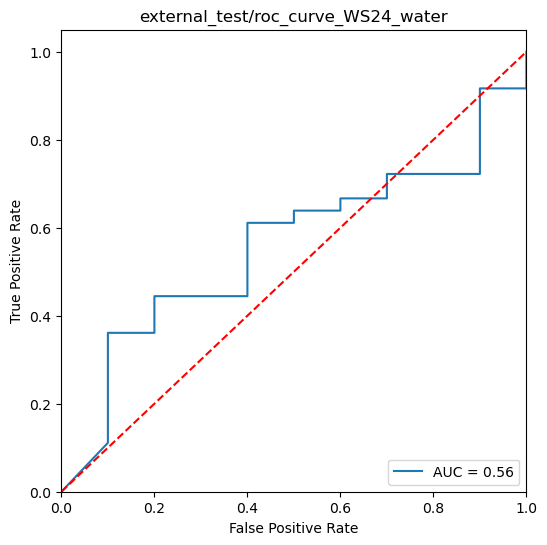

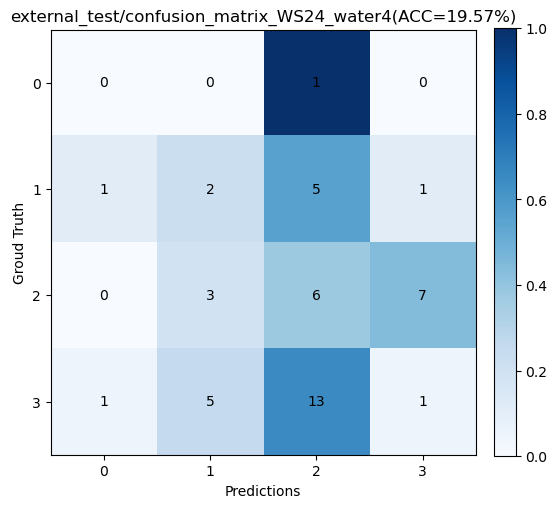

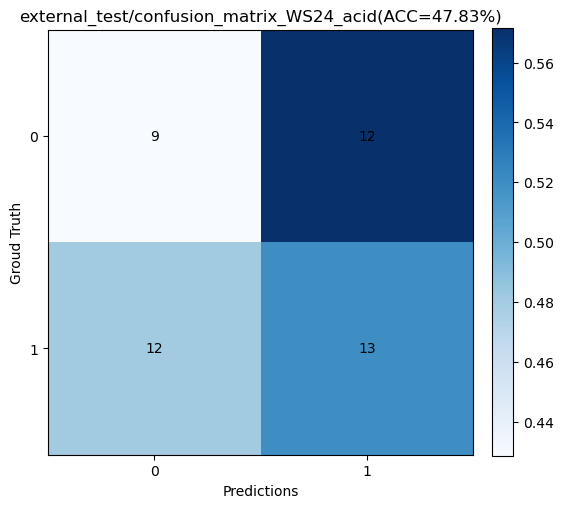

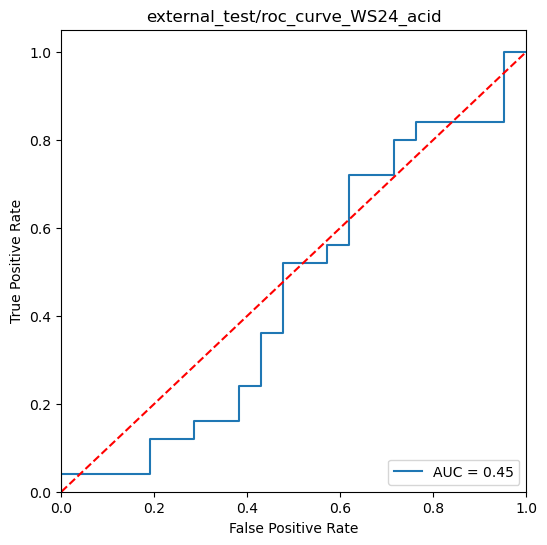

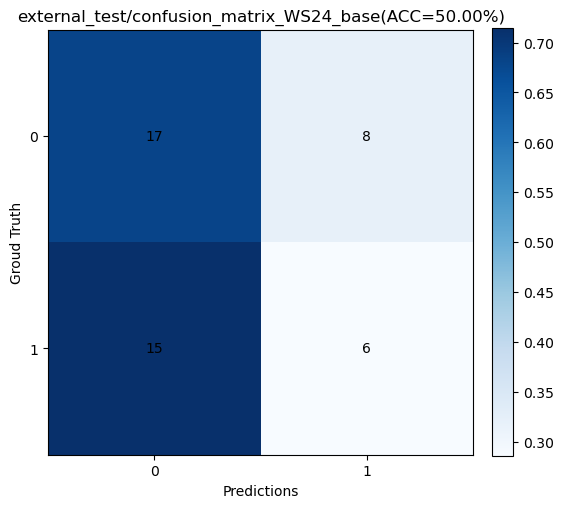

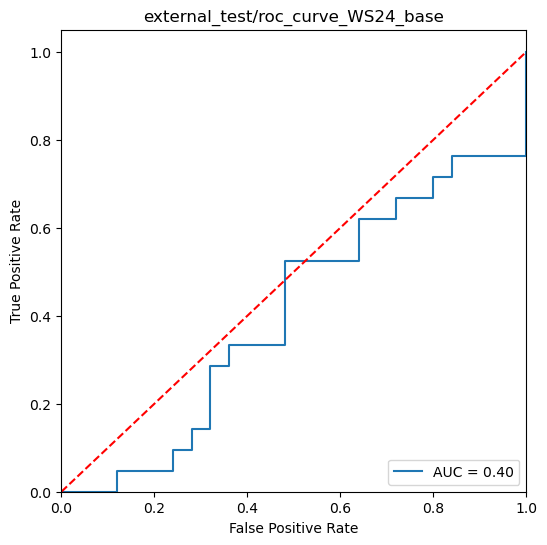

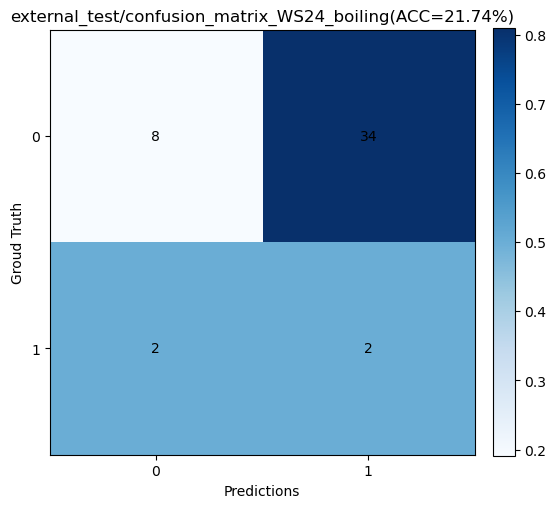

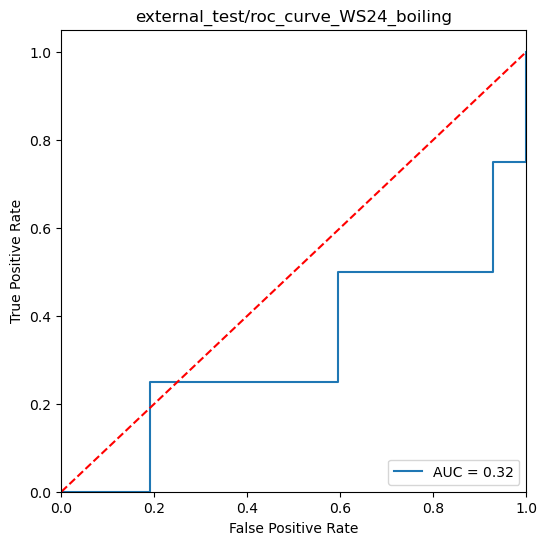

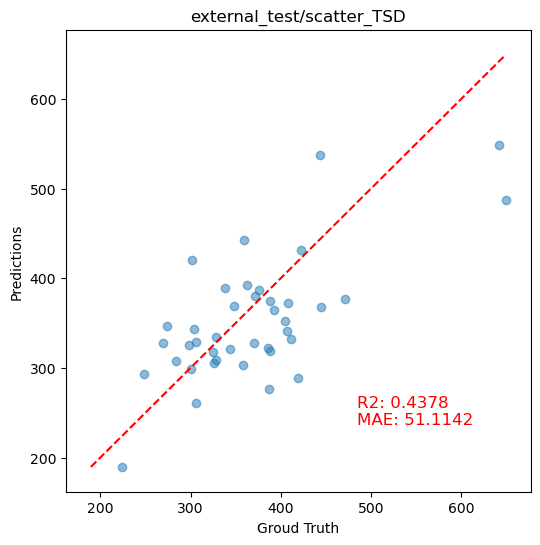

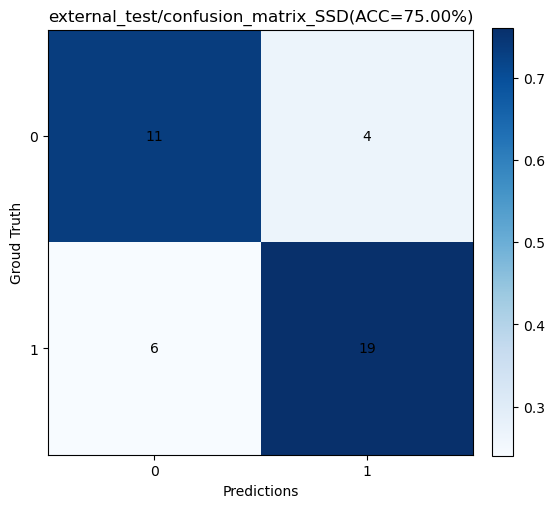

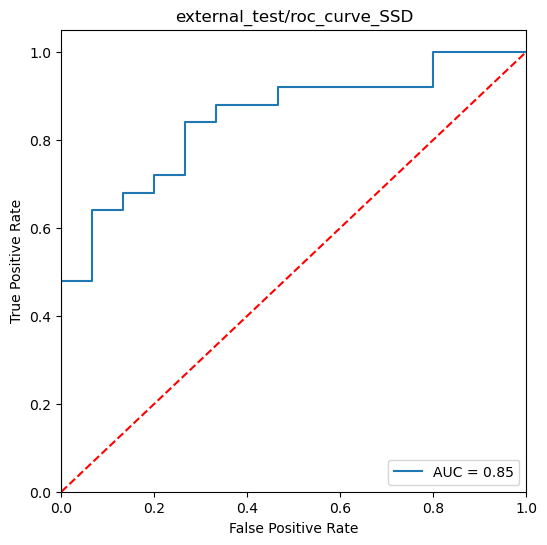

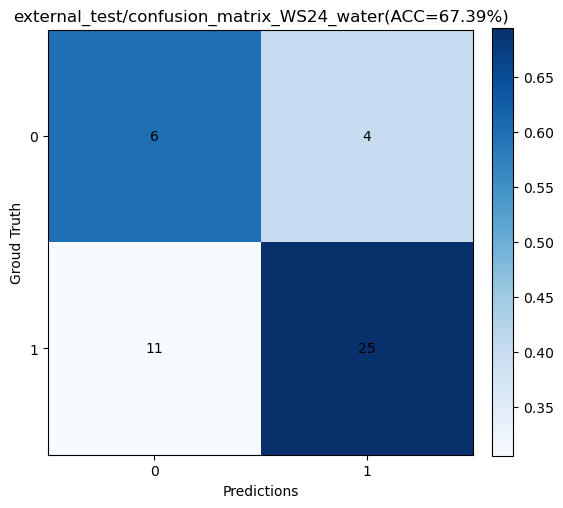

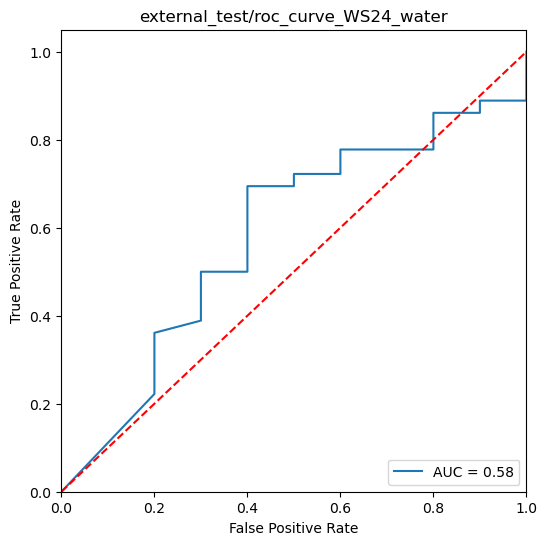

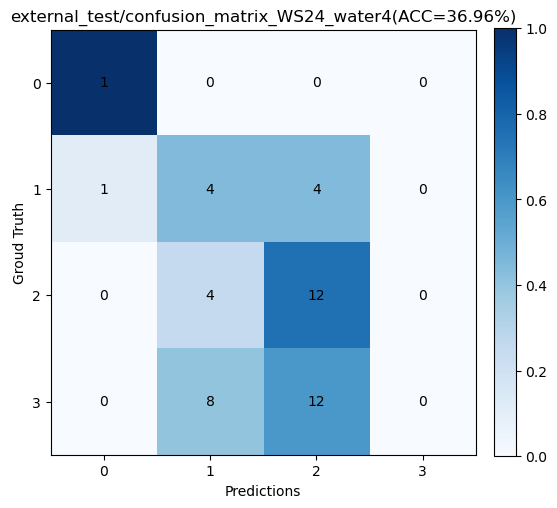

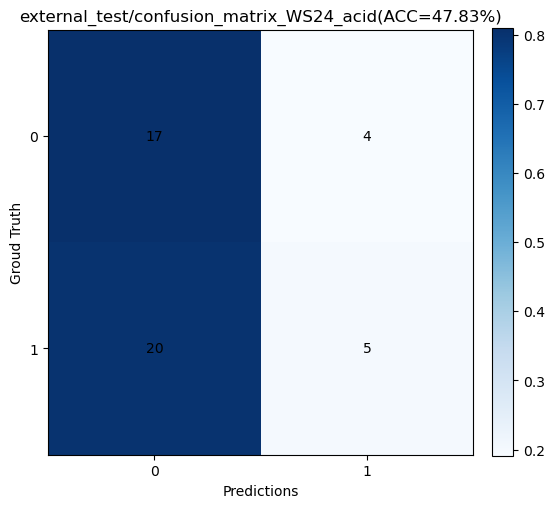

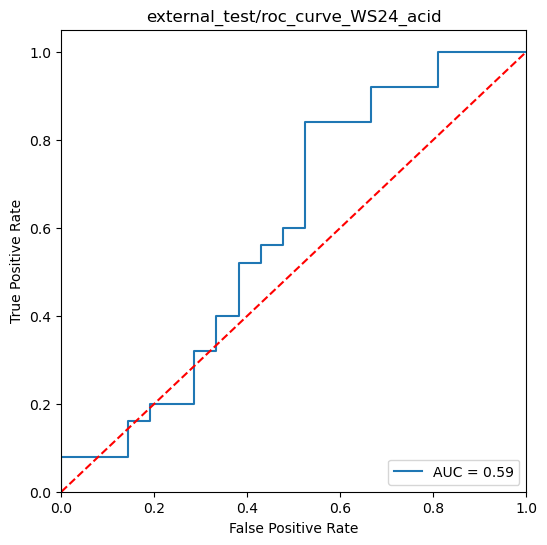

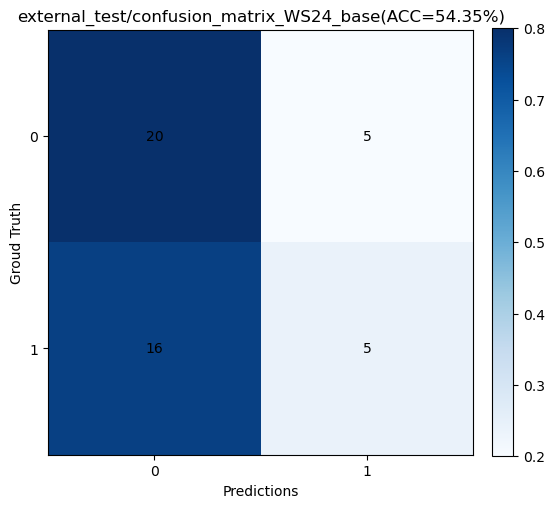

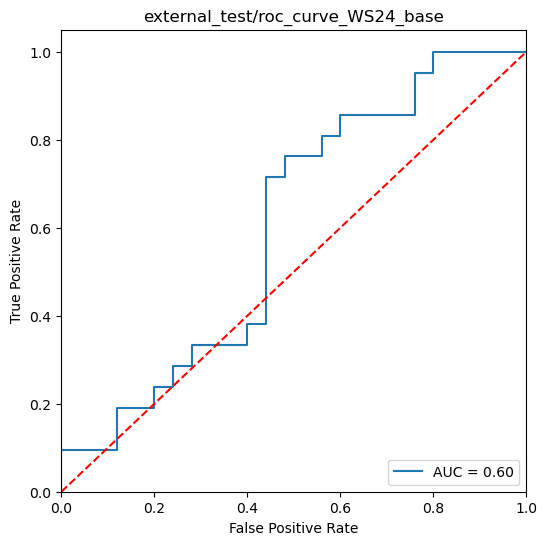

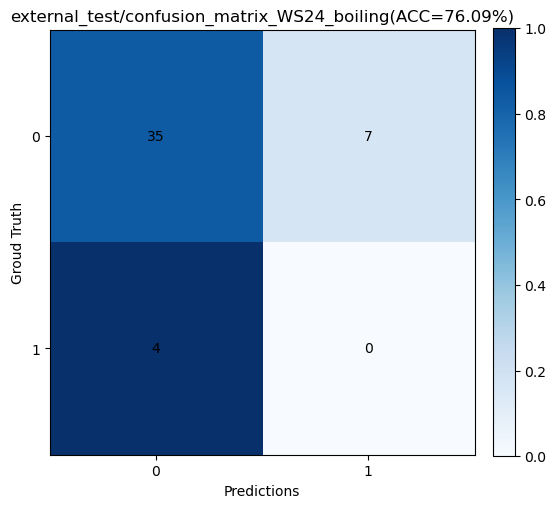

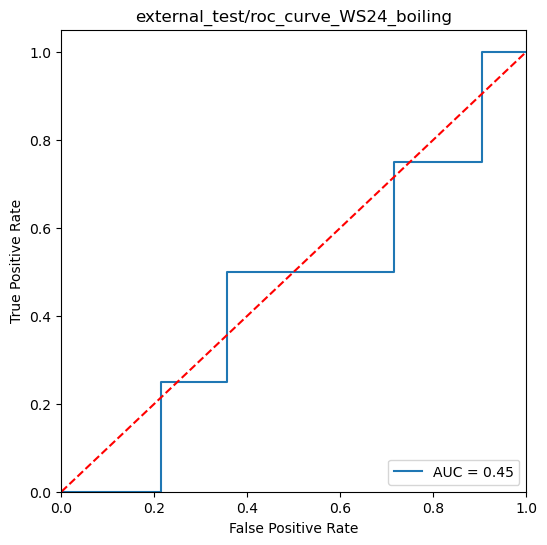

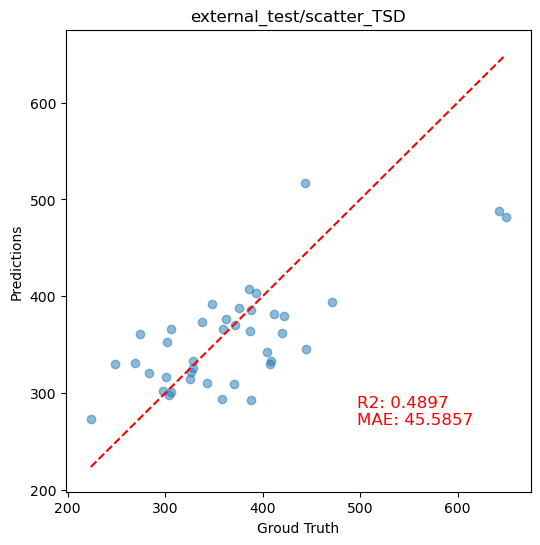

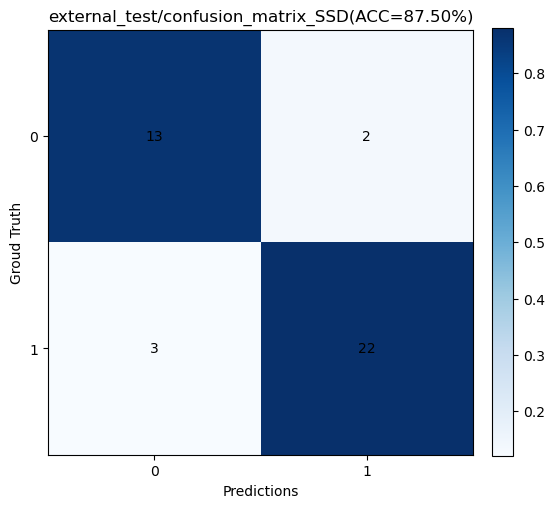

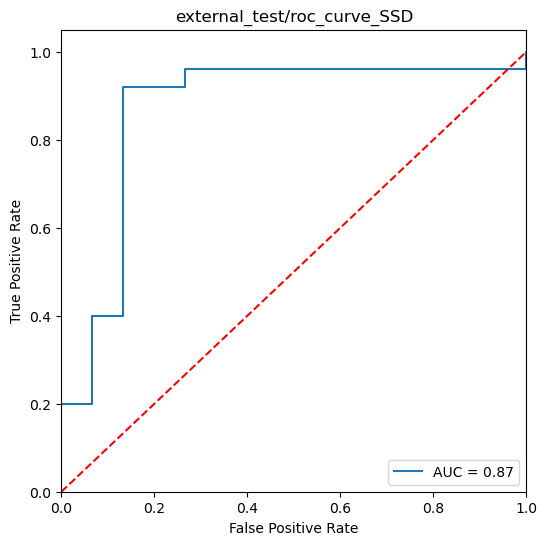

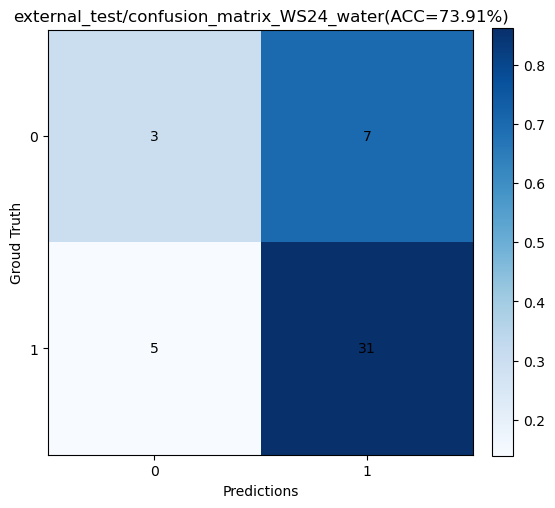

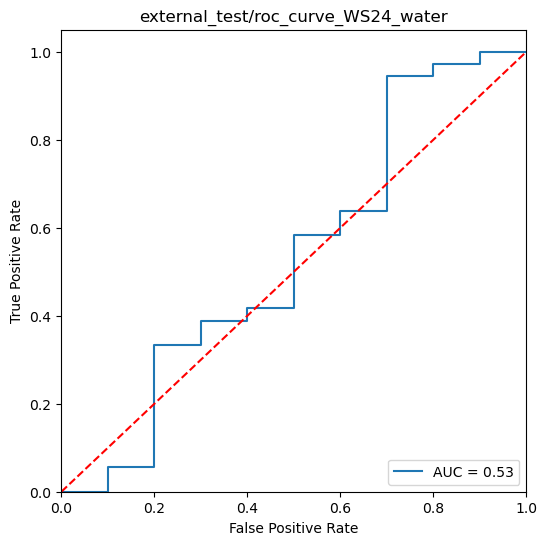

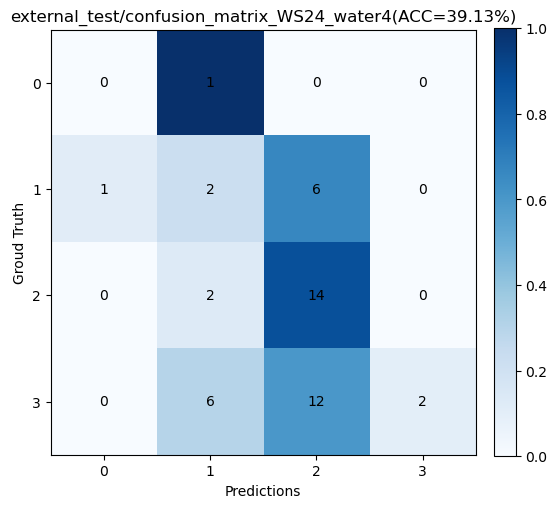

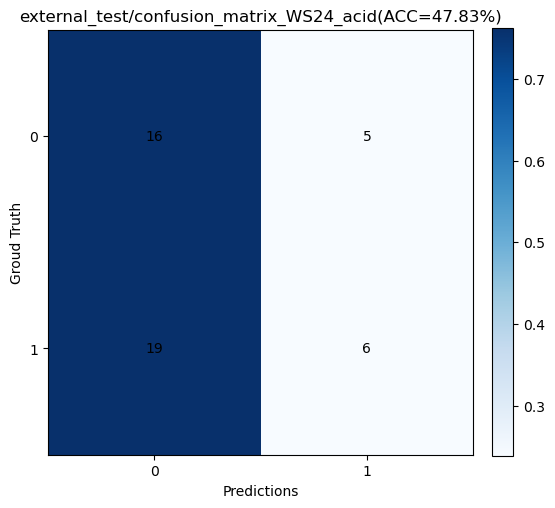

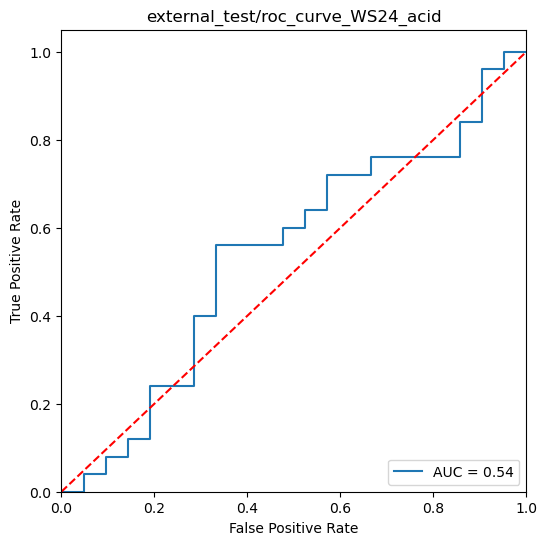

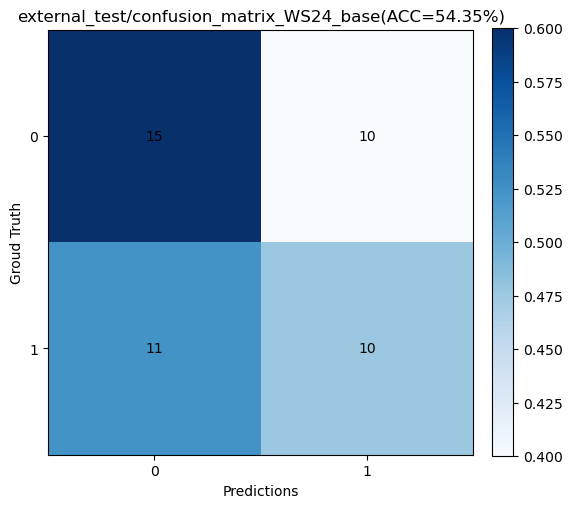

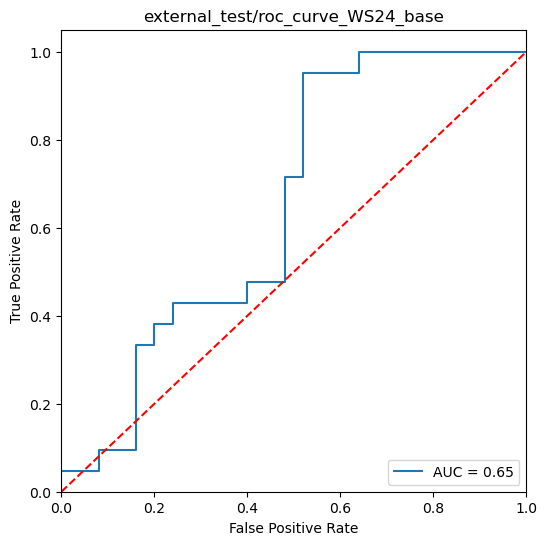

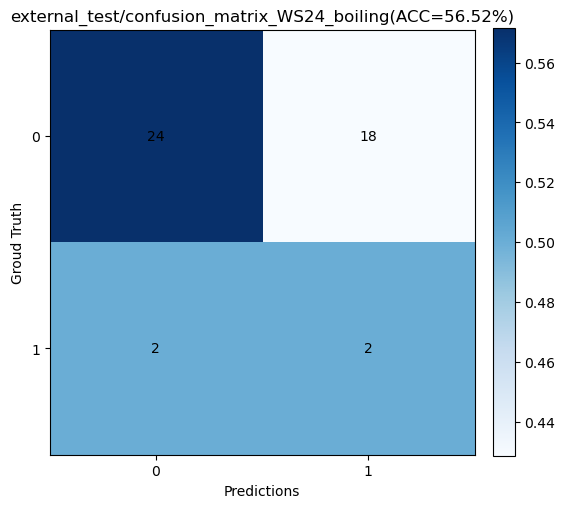

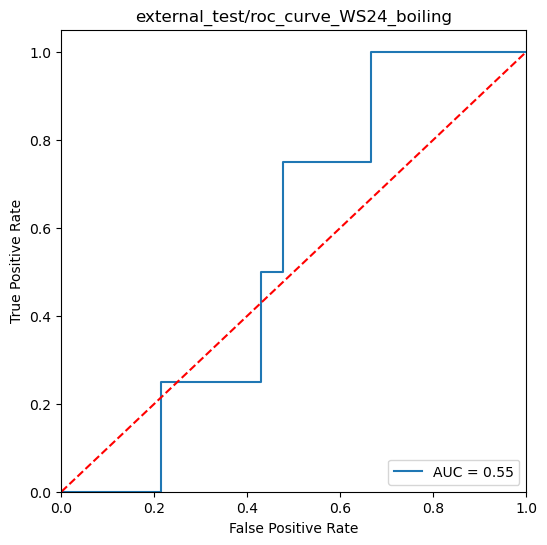

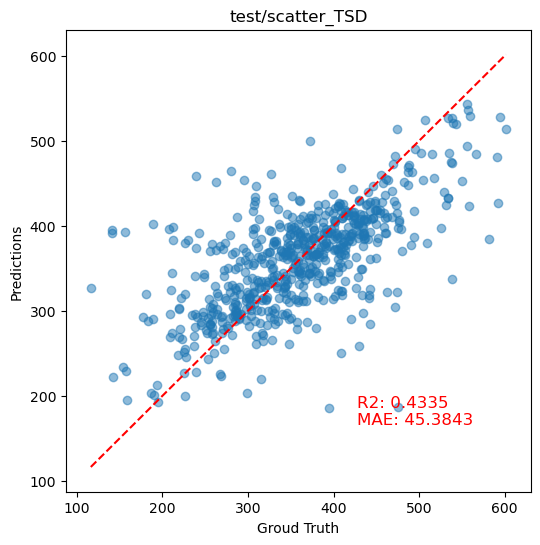

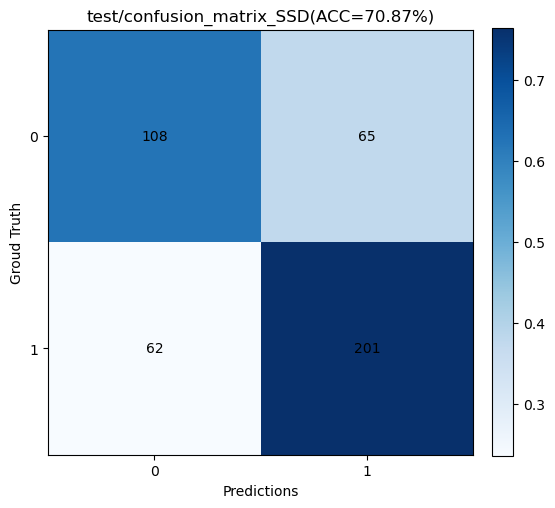

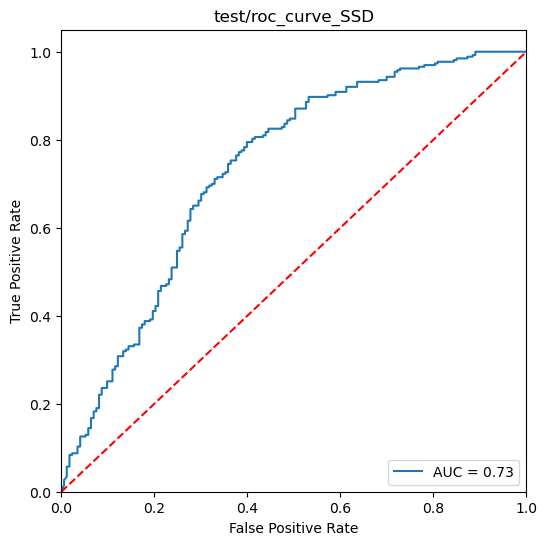

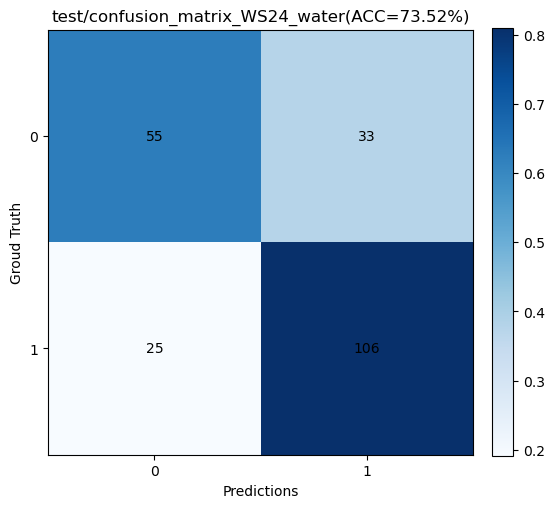

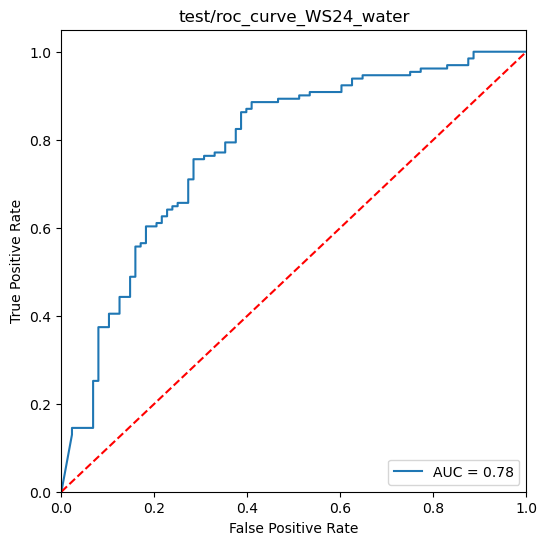

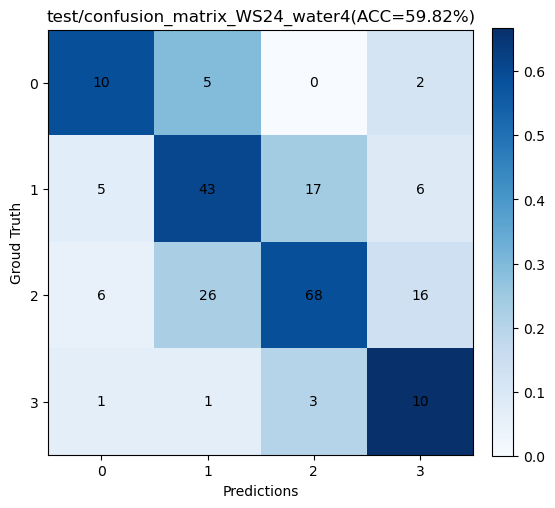

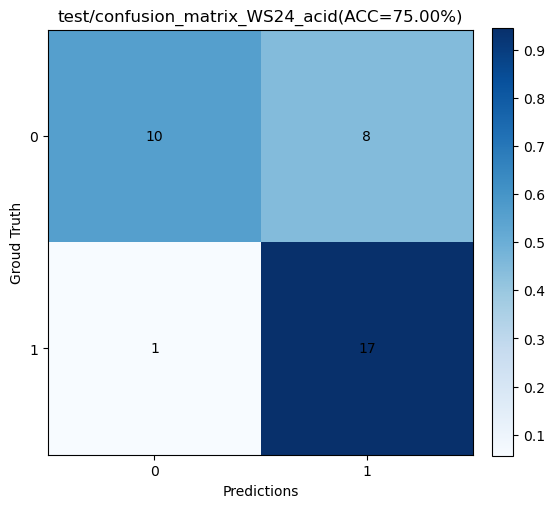

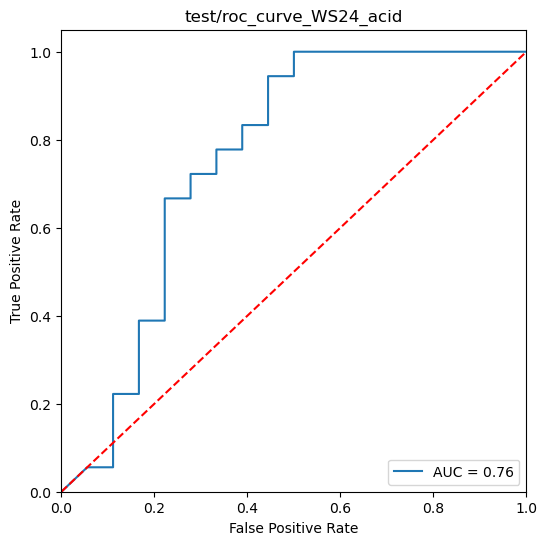

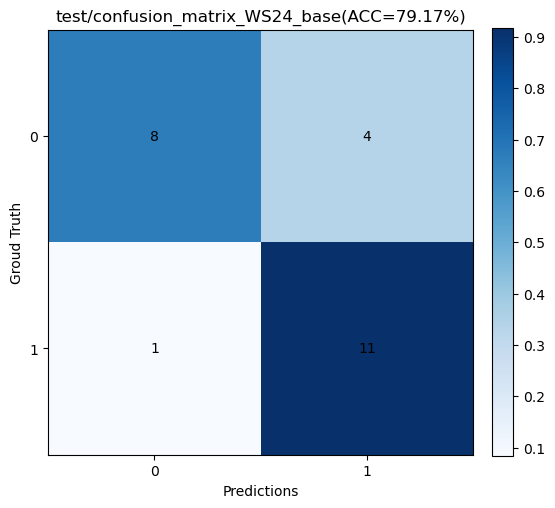

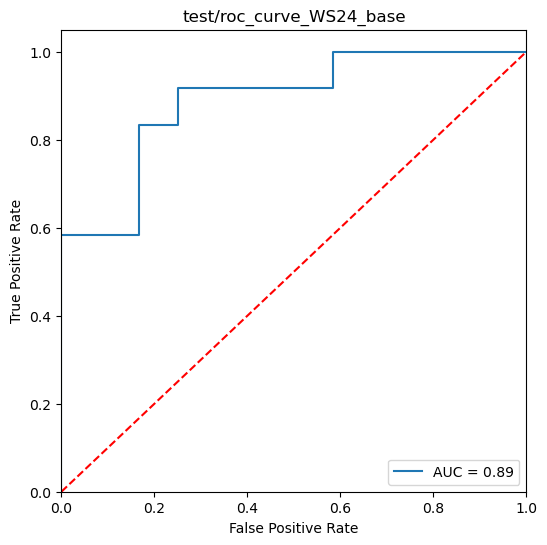

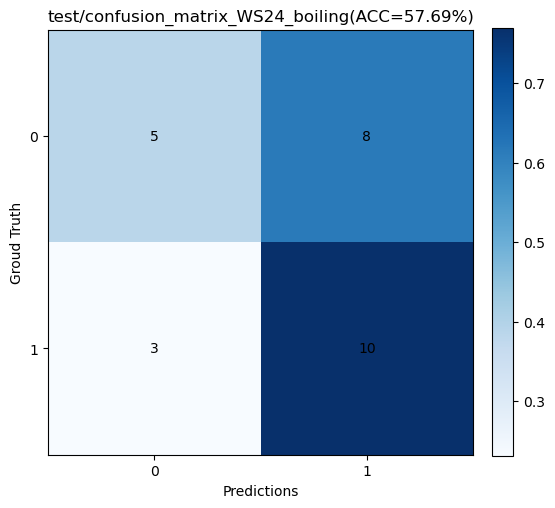

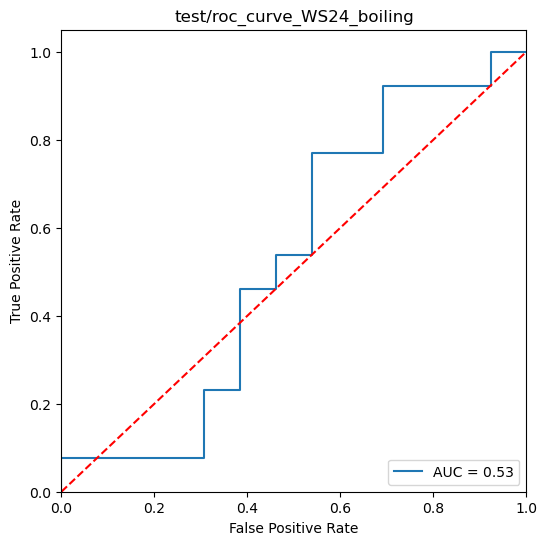

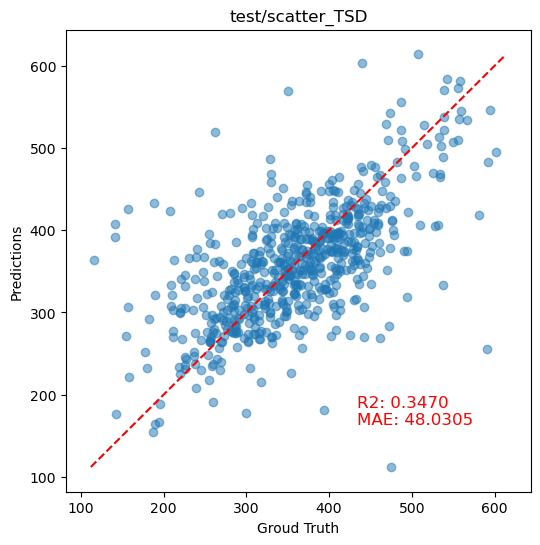

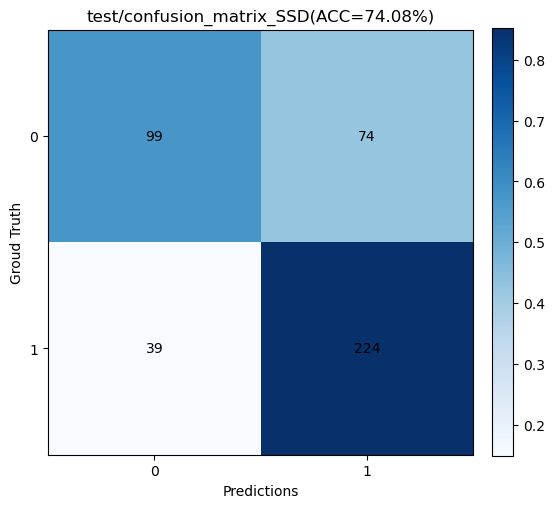

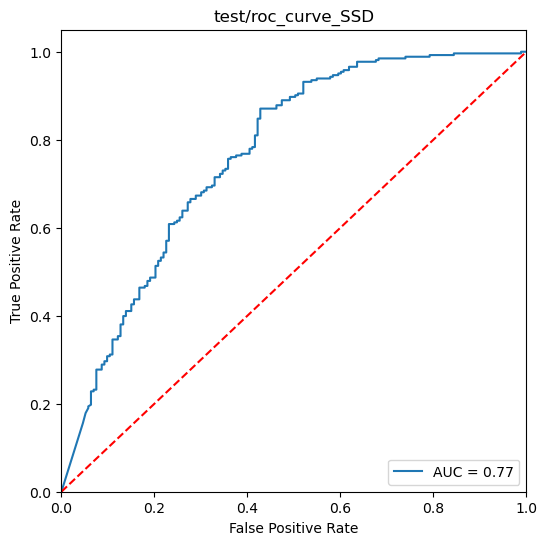

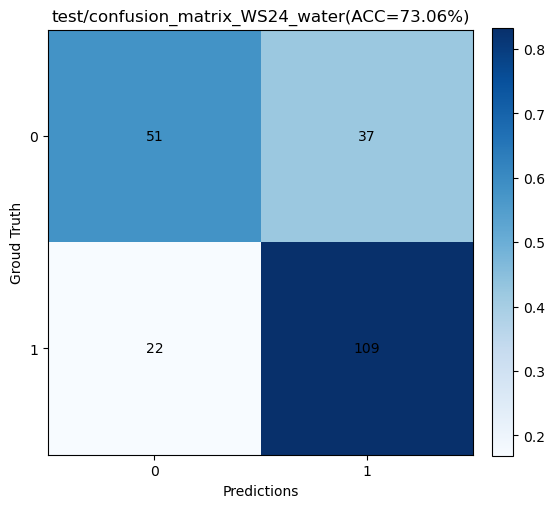

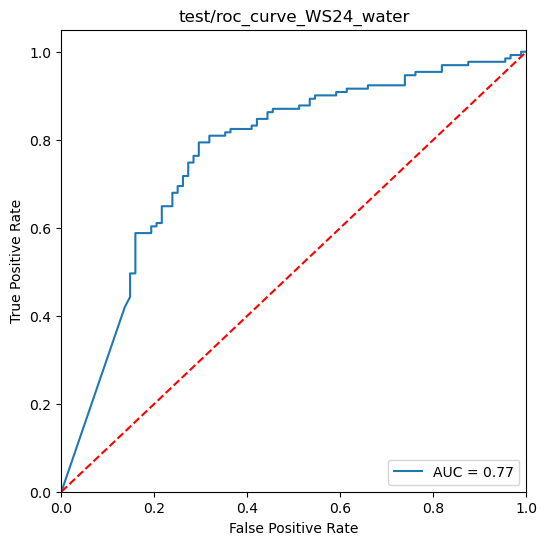

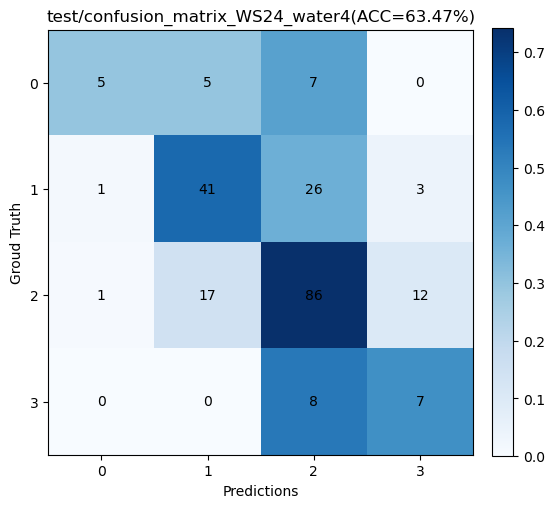

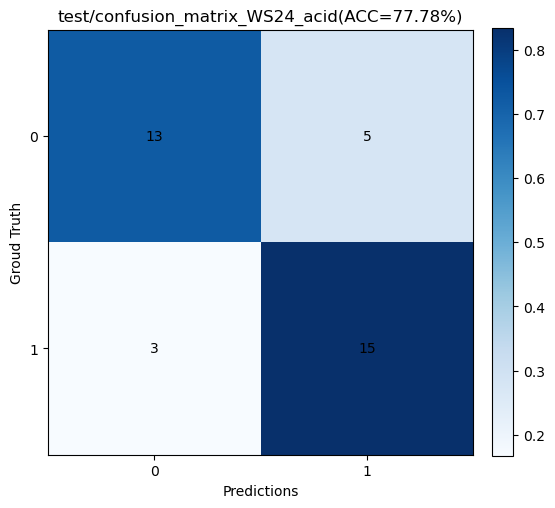

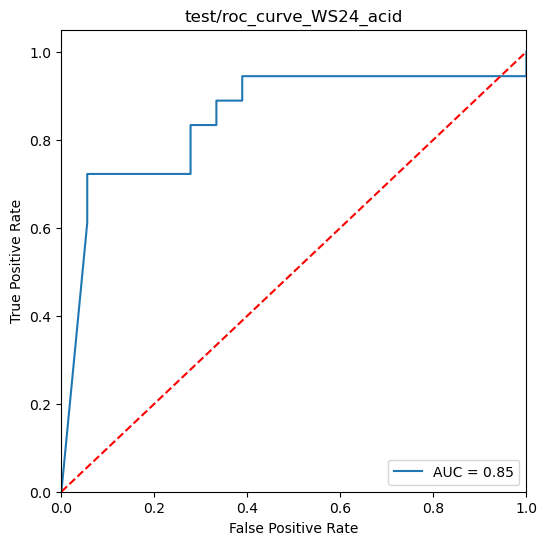

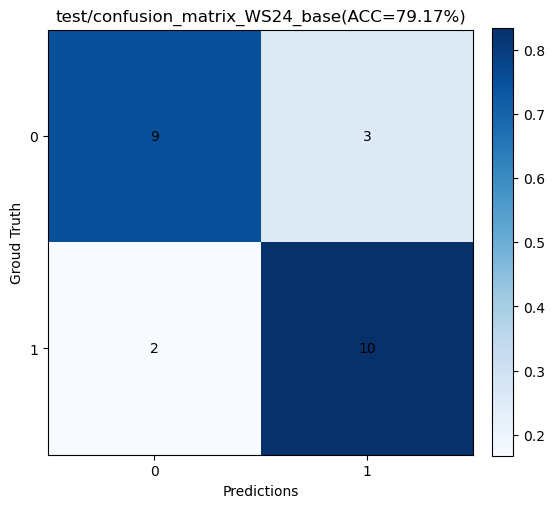

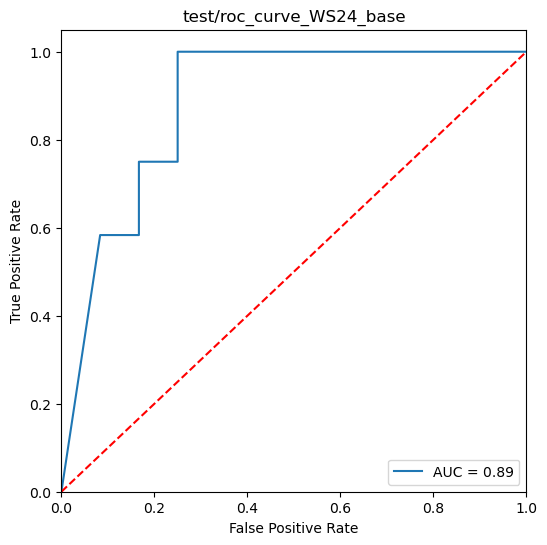

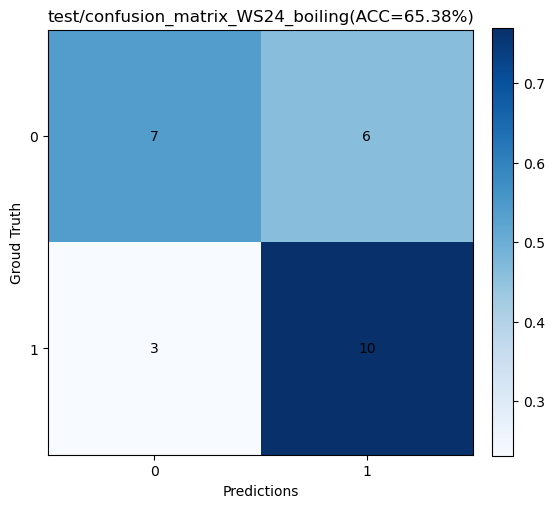

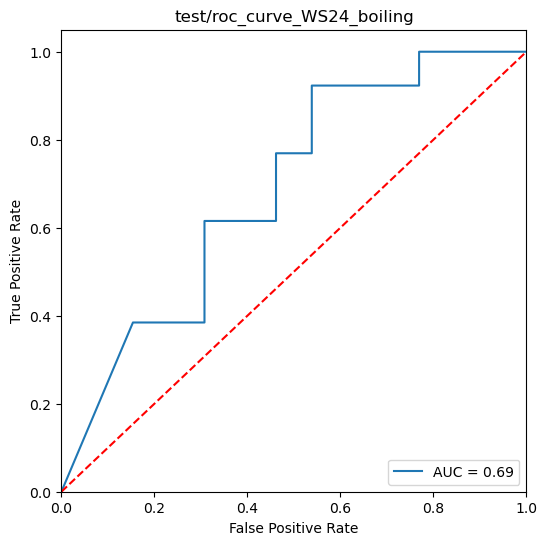

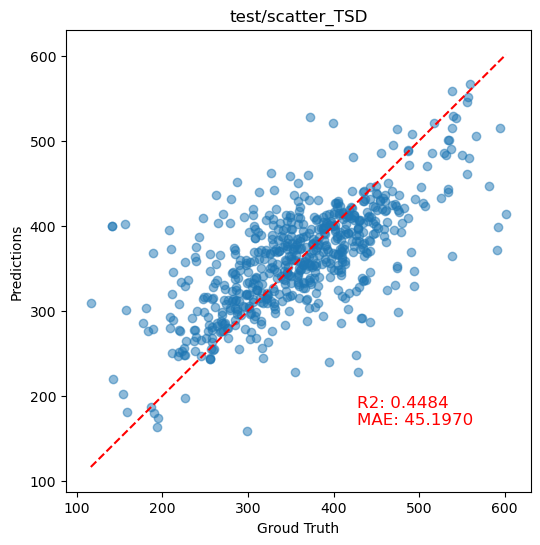

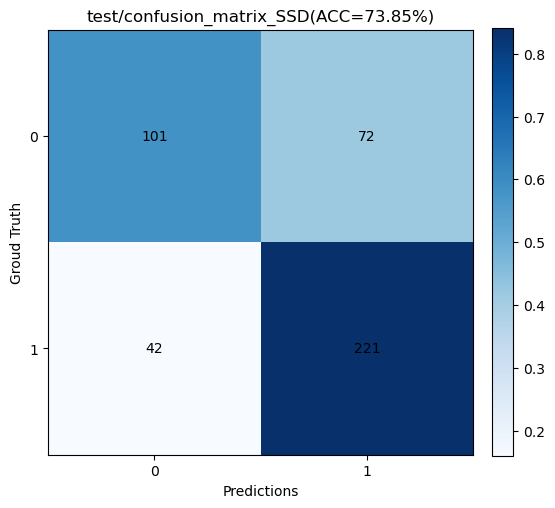

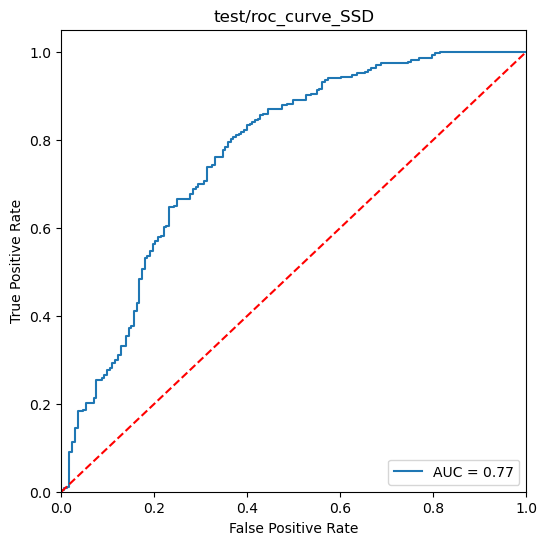

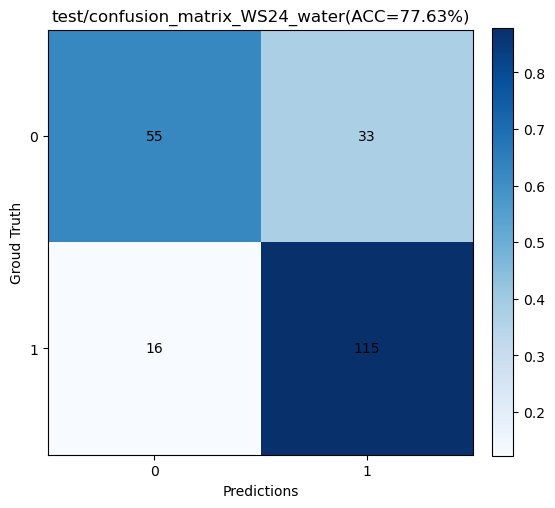

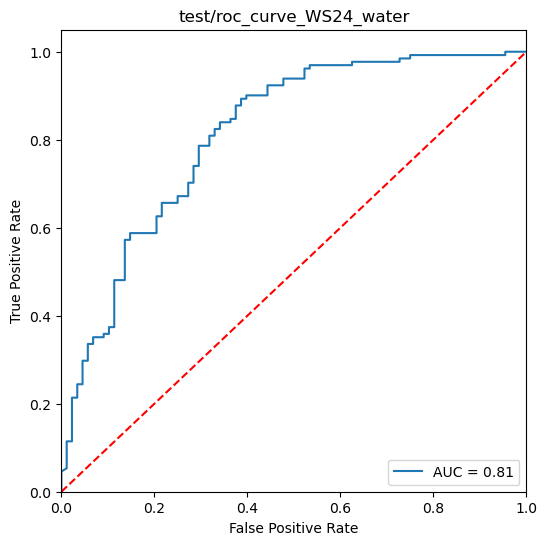

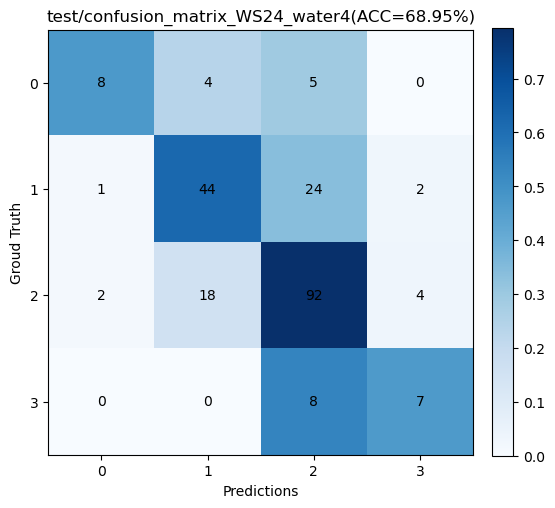

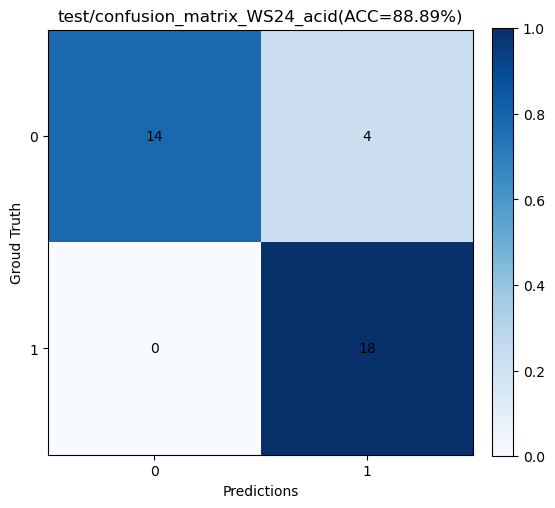

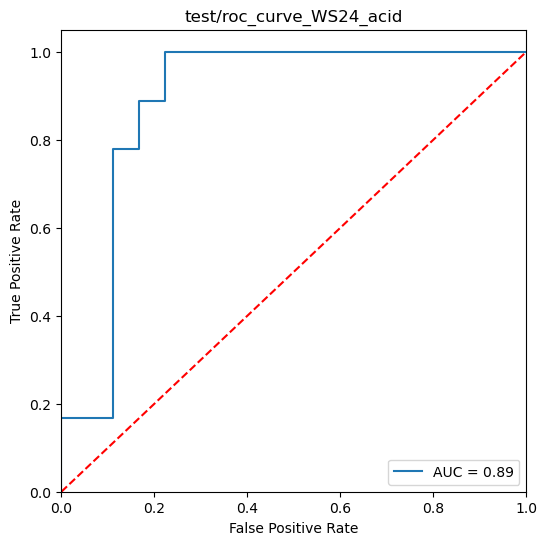

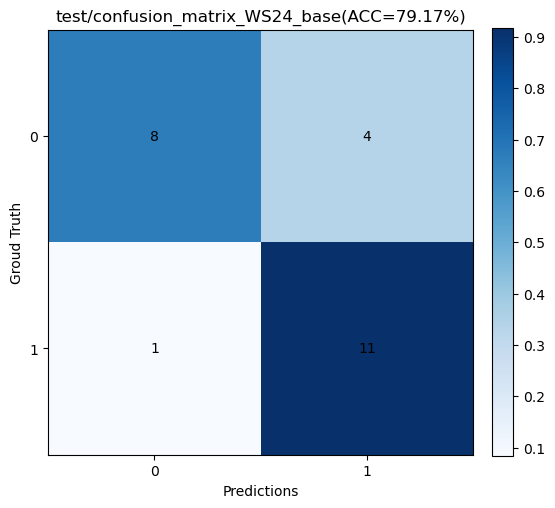

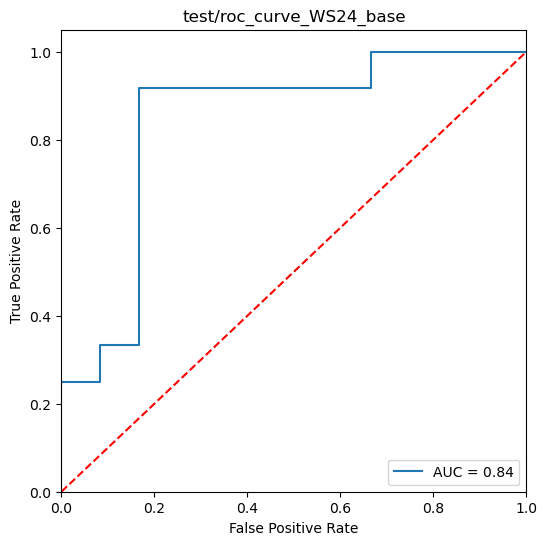

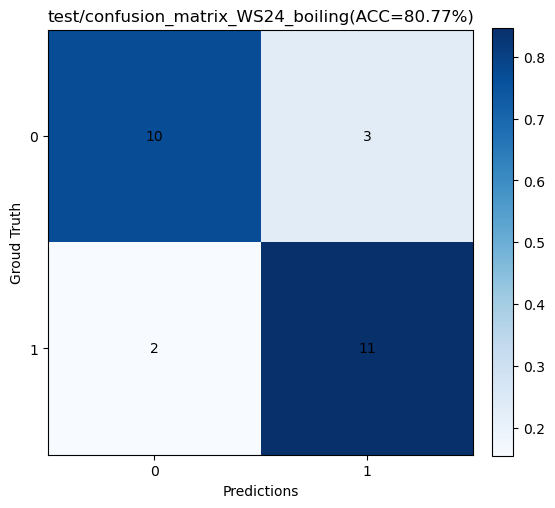

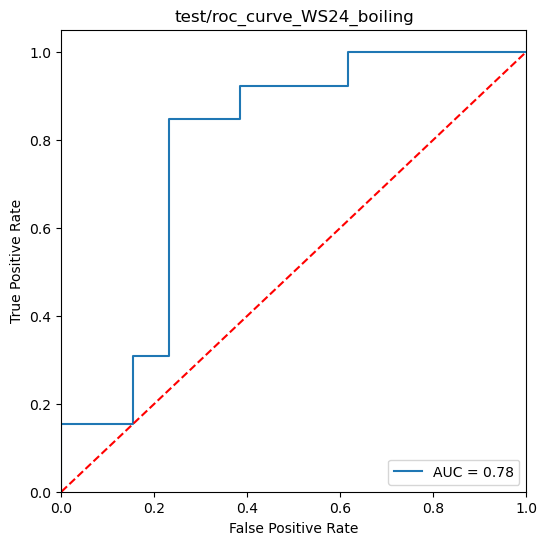

In [8]:

res = {}
result_dir = Path("./CGCNN_MT/evaluation")
data_dirs = [
    "./CGCNN_MT/data/TS_external_test",
    "./CGCNN_MT/data/WS24v2_external_test", 
]
col2tasks = [
    {"ts_label": "TSD", "ss_label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"}
    ]

tasks = [
    "TSD", 
    "SSD",
    "WS24_water",
    "WS24_water4",
    "WS24_acid",
    "WS24_base",
    "WS24_boiling",
    "TSD_SSD_WS24_all",
    "TSD_SSD_WS24_all_attn"
]
model_dirs = [task2models[t] for t in tasks]

split = "external_test"
metric_collections = []
for task in tasks:
    model_dir = task2models[task]["Path"]
    if task in ["TSD_SSD_WS24_all"]:
        model_name = task2models[task]["Model"] + "_multi"
    elif task in ["TSD_SSD_WS24_all_attn"]:
        model_name = "MOFSNN"
    else:
        model_name = task2models[task]["Model"] + "_single"
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
        if all_metrics:
            all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
            all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
            metric_collections.append(all_metrics)

data_dirs = [
    "./CGCNN_MT/data/TSD",
    "./CGCNN_MT/data/SSD", 
    "./CGCNN_MT/data/WS24",
]
col2tasks = [
    {"Label": "TSD"},
    {"Label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"},
    ]
for task in tasks:
    model_dir = task2models[task]["Path"]
    if task in ["TSD_SSD_WS24_all"]:
        model_name = task2models[task]["Model"] + "_multi"
    elif task in ["TSD_SSD_WS24_all_attn"]:
        model_name = "MOFSNN"
    else:
        model_name = task2models[task]["Model"] + "_single"
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        for split in ["test"]:
            all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
            if all_metrics:
                all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
                all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
                metric_collections.append(all_metrics)
# pd.DataFrame(res).T.to_csv(result_dir/"all_metrics.csv")

In [9]:
metric_collections

[{'TSD/R2Score': 0.41370295081955355,
  'TSD/MeanAbsoluteError': 49.990334,
  'Model': 'cgcnn_raw_single',
  'Version': 'version_29',
  'Split': 'external_test'},
 {'SSD/Accuracy': 0.8,
  'SSD/BalancedAccuracy': 0.8266666666666667,
  'SSD/F1Score': 0.797979797979798,
  'SSD/MatthewsCorrCoef': 0.6333794997024097,
  'SSD/AUROC': 0.9600000000000001,
  'Model': 'cgcnn_raw_single',
  'Version': 'version_4',
  'Split': 'external_test'},
 {'WS24_water/Accuracy': 0.5869565217391305,
  'WS24_water/BalancedAccuracy': 0.4111111111111111,
  'WS24_water/F1Score': 0.4138162307176392,
  'WS24_water/MatthewsCorrCoef': -0.17190889899208114,
  'WS24_water/AUROC': 0.5583333333333333,
  'Model': 'cgcnn_raw_single',
  'Version': 'version_29',
  'Split': 'external_test'},
 {'WS24_water4/Accuracy': 0.1956521739130435,
  'WS24_water4/BalancedAccuracy': 0.16180555555555556,
  'WS24_water4/F1Score': 0.14304368996503034,
  'WS24_water4/MatthewsCorrCoef': -0.19231958302221358,
  'WS24_water4/AUROC': 0.34976851851

In [10]:
reversed_dict = {}
tasks = [
    "TSD", 
    "SSD",
    "WS24_water",
    "WS24_water4",
    "WS24_acid",
    "WS24_base",
    "WS24_boiling",]
for metric_d in metric_collections:
    model = metric_d["Model"]
    version = metric_d["Version"]
    split = metric_d["Split"]
    for metric_name, metric_value in metric_d.items():
        if metric_name in ["Model", "Version", "Split"]:
            continue
        task_name, metric_name = metric_name.split("/")
        if (task_name, model, version, split) not in reversed_dict:
            reversed_dict[(task_name, model, version, split)] = {metric_name: metric_value}
        else:
            reversed_dict[(task_name, model, version, split)][metric_name] = metric_value
records = []
for k, v in reversed_dict.items():
    task_name, model, version, split = k
    v.update({"Model": model, "Version": version, "Split": split, "Task": task_name})
    records.append(v)
df_res = pd.DataFrame(records)
model_map = {
    "cgcnn_raw_multi": "CGCNN_MT",
    "cgcnn_raw_single": "CGCNN_SG",
    "MOFSNN": "MOFSNN",
    
}
metric_name_map = {
    "R2Score": "R2",
    "MeanAbsoluteError": "MAE",
    "Accuracy": "ACC",
    "BalancedAccuracy": "BACC",
    "F1Score": "F1",
    "MatthewsCorrCoef": "MCC",
}
df_res["Model"] = df_res["Model"].map(model_map).copy()
df_res.rename(columns=metric_name_map, inplace=True)
for split in df_res["Split"].unique():
    print("-"*100)
    print(f"Split: {split}")
    sub_df = df_res[df_res["Split"] == split].copy()
    sub_df.set_index(["Task", "Model"], inplace=True)
    sub_df.drop(columns=["Split", "Version", "F1", "MCC"], inplace=True)
    sub_df.to_excel(saved_dir/f"CGCNN_results_{split}.xlsx")

    df_ml_metrics = pd.read_excel(saved_dir/f'ML_results_{split}.xlsx', index_col=[0,1])
    df_ml_cgcnn = pd.concat([sub_df, df_ml_metrics.loc[[(task, "Baseline") for task in tasks]]], axis=0)
    # df_ml_cgcnn.sort_index(inplace=True)
    if "Algorithm" in df_ml_cgcnn.columns:
        df_ml_cgcnn.drop(columns=["Algorithm"], inplace=True)
    index = []
    for task in ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]:
        for model in ["Baseline", "CGCNN_SG", "CGCNN_MT", "MOFSNN"]:
            index.append((task, model))
    df_ml_cgcnn = df_ml_cgcnn.reindex(index=index)
    df_ml_cgcnn.to_excel(saved_dir/f"CGCNN_ML_results_{split}.xlsx")
    print(df_ml_cgcnn)

----------------------------------------------------------------------------------------------------
Split: external_test
                             R2        MAE       ACC      BACC     AUROC
Task         Model                                                      
TSD          Baseline  0.349546  53.829348       NaN       NaN       NaN
             CGCNN_SG  0.413703  49.990334       NaN       NaN       NaN
             CGCNN_MT  0.437760  51.114208       NaN       NaN       NaN
             MOFSNN    0.489687  45.585678       NaN       NaN       NaN
SSD          Baseline       NaN        NaN  0.750000  0.760000  0.856000
             CGCNN_SG       NaN        NaN  0.800000  0.826667  0.960000
             CGCNN_MT       NaN        NaN  0.750000  0.746667  0.848000
             MOFSNN         NaN        NaN  0.875000  0.873333  0.866667
WS24_water   Baseline       NaN        NaN  0.608700  0.388900  0.538900
             CGCNN_SG       NaN        NaN  0.586957  0.411111  0.558333
  

In [11]:
df_ml_metrics

R2    MAE   ACC  BACC  AUROC Algorithm
Task         Model                                              
TSD          Baseline   0.47  45.43   NaN   NaN    NaN        RF
             Reference  0.46  44.00   NaN   NaN    NaN        GP
SSD          Baseline    NaN    NaN  0.76  0.73   0.83        RF
             Reference   NaN    NaN  0.76   NaN   0.81        GP
WS24_water   Baseline    NaN    NaN  0.71  0.69   0.77        RF
             Reference   NaN    NaN  0.77  0.74   0.83        RF
WS24_water4  Baseline    NaN    NaN  0.64  0.52   0.85        RF
             Reference   NaN    NaN  0.66  0.51   0.82        RF
WS24_acid    Baseline    NaN    NaN  0.81  0.81   0.92        GP
             Reference   NaN    NaN  0.78  0.78   0.85        RF
WS24_base    Baseline    NaN    NaN  0.71  0.71   0.74        GP
             Reference   NaN    NaN  0.70  0.70   0.78        RF
WS24_boiling Baseline    NaN    NaN  0.73  0.73   0.68        RF
             Reference   NaN    NaN  0.65  0.65   0.69        RF

## MOFSNN trained on subset of datasets

In [12]:
task2models = {'TSD_SSD_WS24_water_WS24_water4': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn/version_13'},
 'WS24_all': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_34'},
 'TSD_SSD_WS24_all_attn': {'Model': 'att_cgcnn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_43'}}

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


task_types:  ['regression', 'classification', 'classification', 'classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 64
extra_fea_len: 32
h_fea_len: 144
n_conv: 8
n_h: 10
att_S: 64
dropout_prob: 0.8
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
task_att_type: se

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4487, TSD/test_MeanAbsoluteError: 46.2416


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn@version_13/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 64
extra_fea_len: 32
h_fea_len: 144
n_conv: 8
n_h: 10
att_S: 64
dropout_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn@version_13/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 64
extra_fea_len: 32
h_fea_len: 144
n_conv: 8
n_h: 10
att_S: 64
dropout_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_seed42_att_cgcnn@version_13/test_metrics.csv
task_types:  ['classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 240
extra_fea_len: 28
h_fea_len: 128
n_conv: 9
n_h

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 4
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 240
extra_fea_len: 28
h_fea_len: 128
n_conv: 9
n_h: 9
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp: 2.0
dwa_alpha: 0.8
atom_layer_norm: True
task_att_type: self
data_dir: ./CGCNN_MT/data
dl_sampler: random
loss_aggregation: fixed_weight_sum
m

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_34/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fe

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4484, TSD/test_MeanAbsoluteError: 45.1970


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zhangsd/repos/MOFSNN/CGCNN_MT/module/module_utils.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv


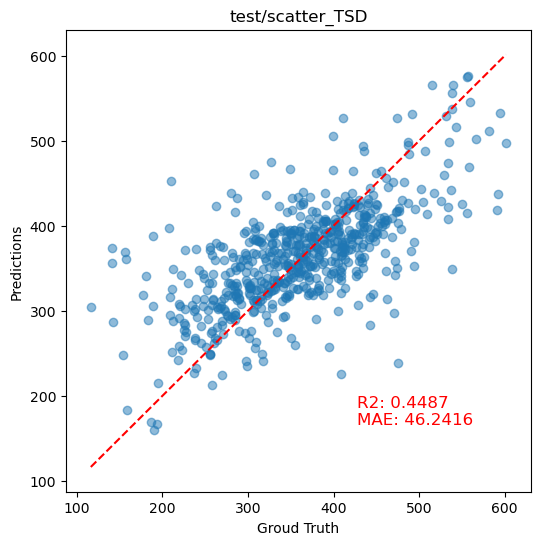

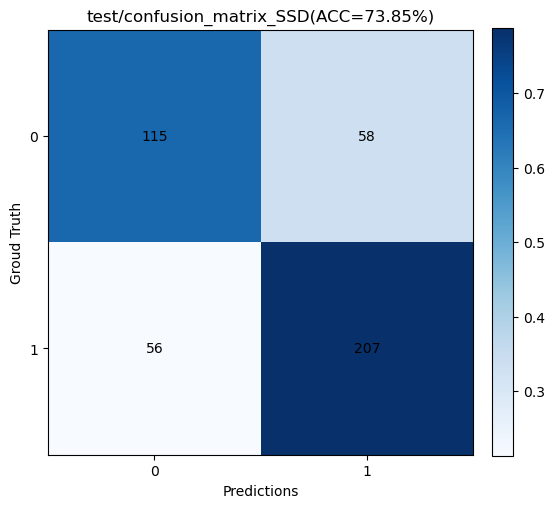

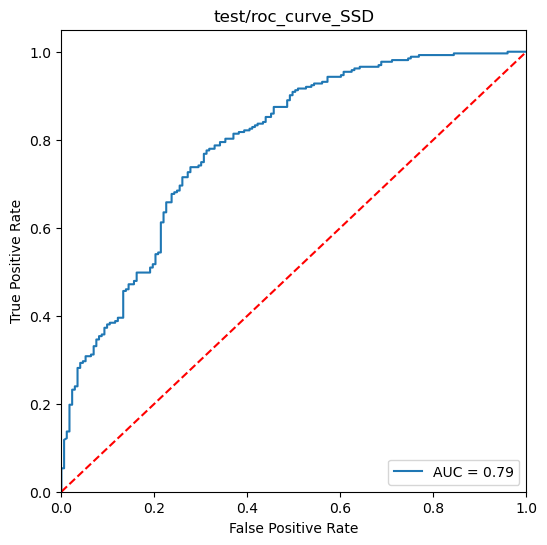

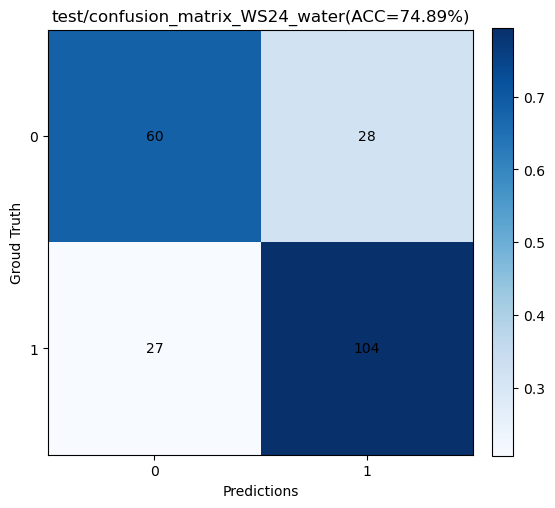

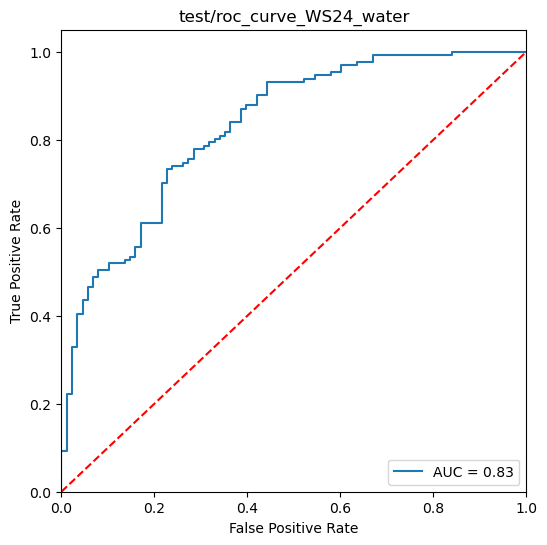

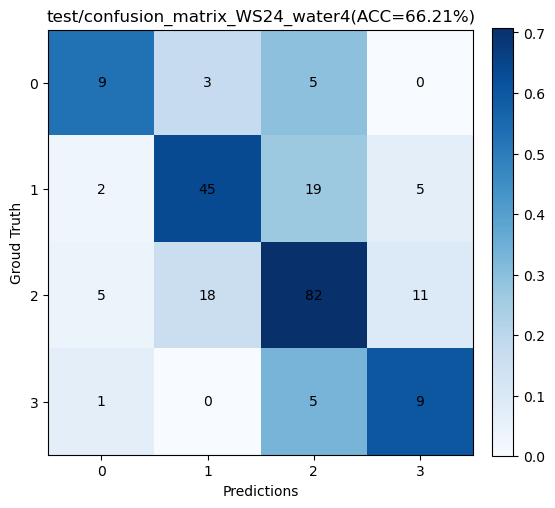

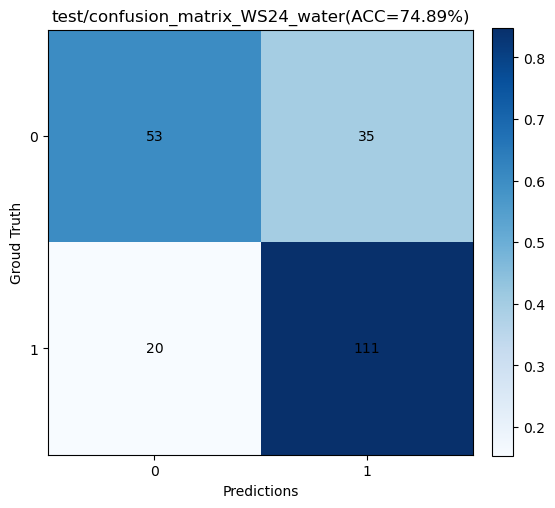

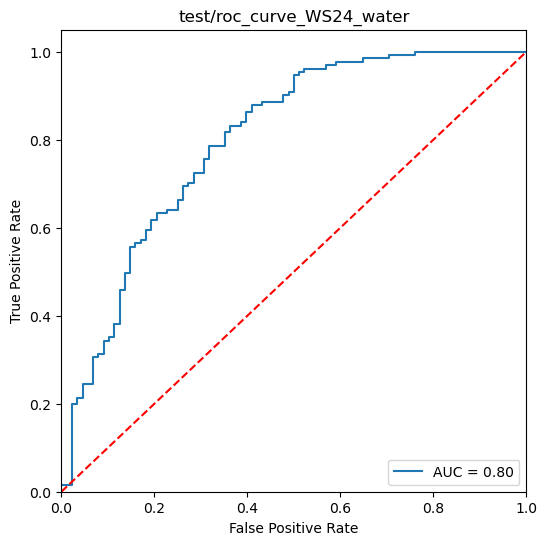

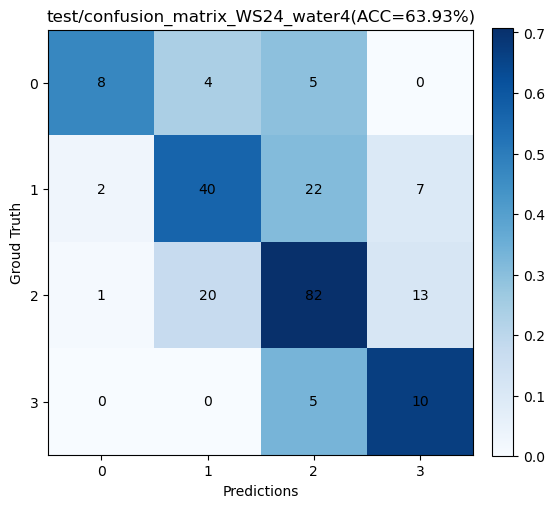

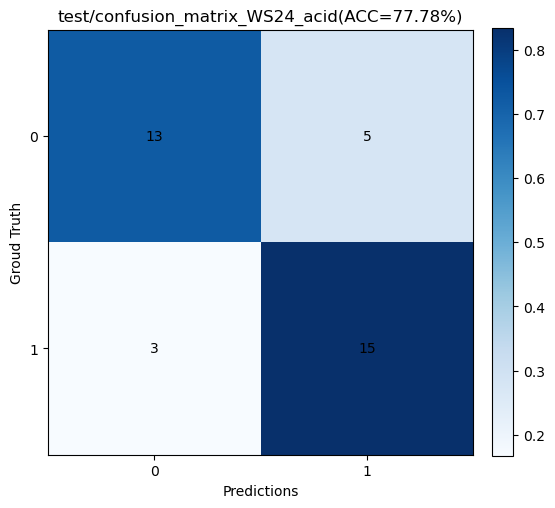

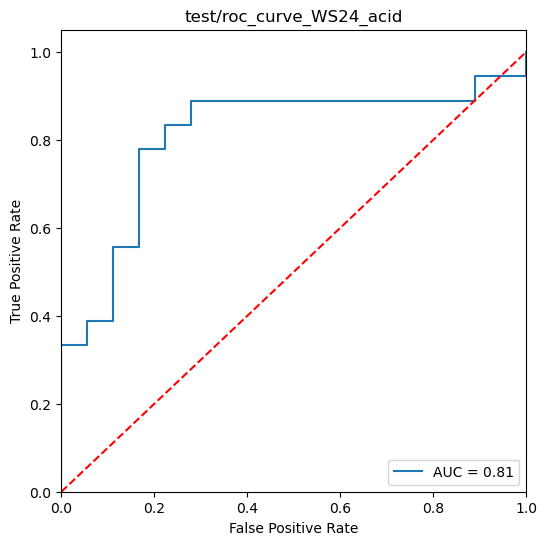

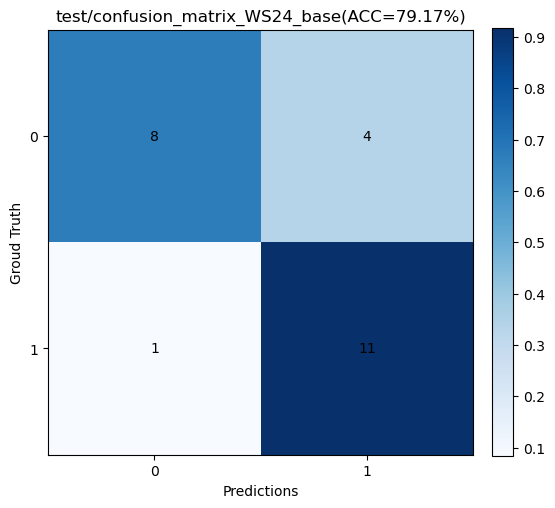

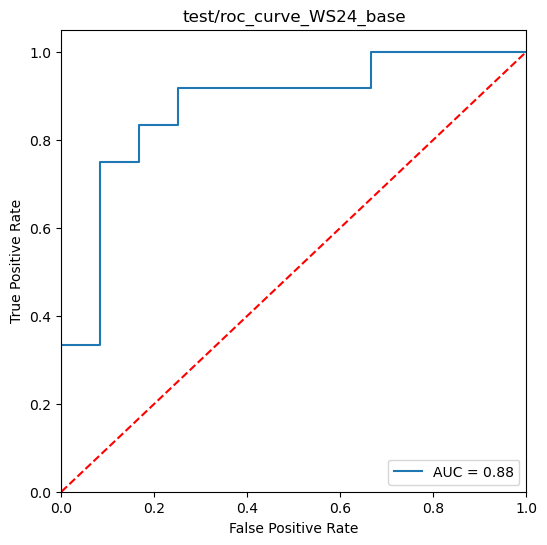

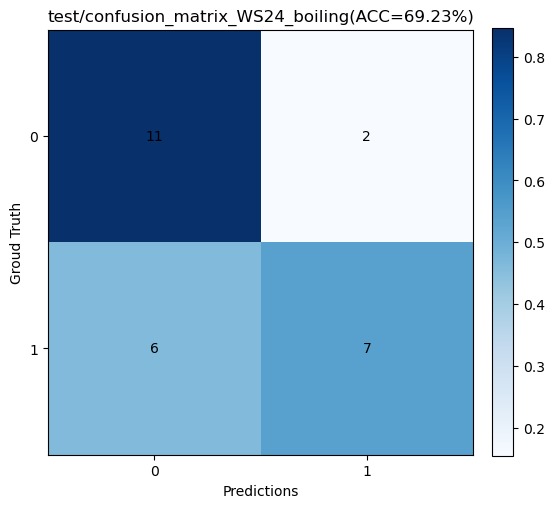

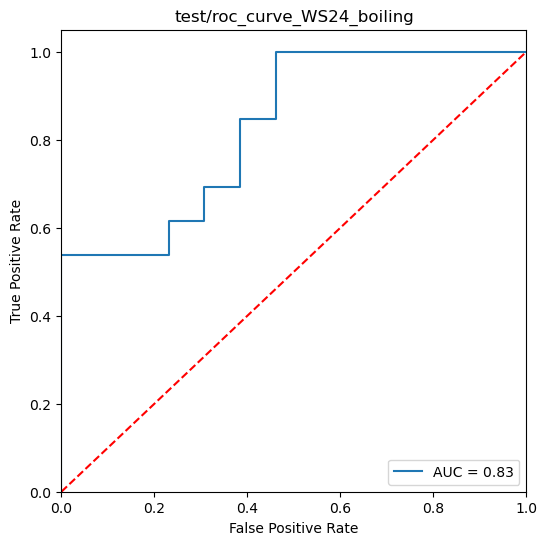

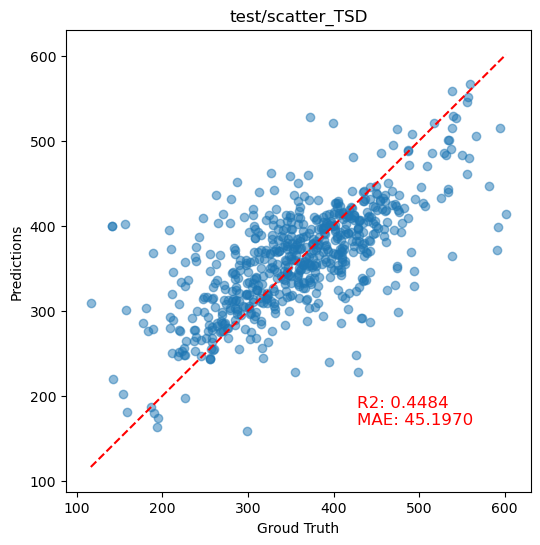

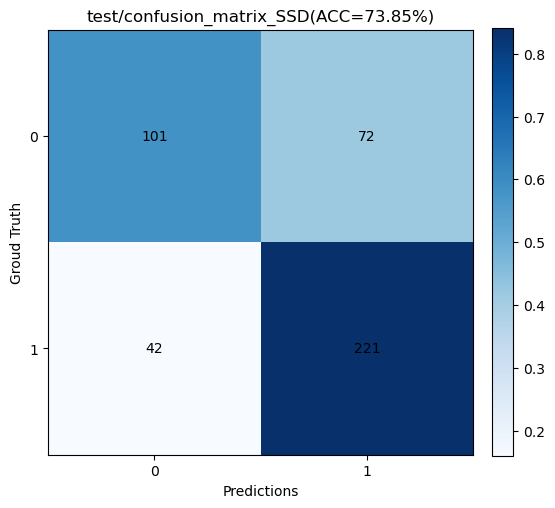

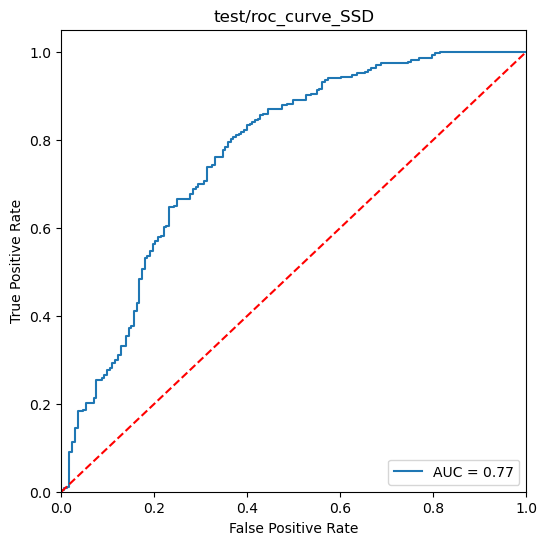

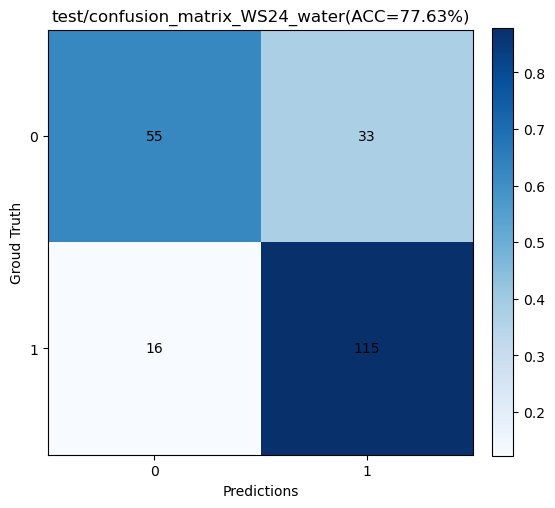

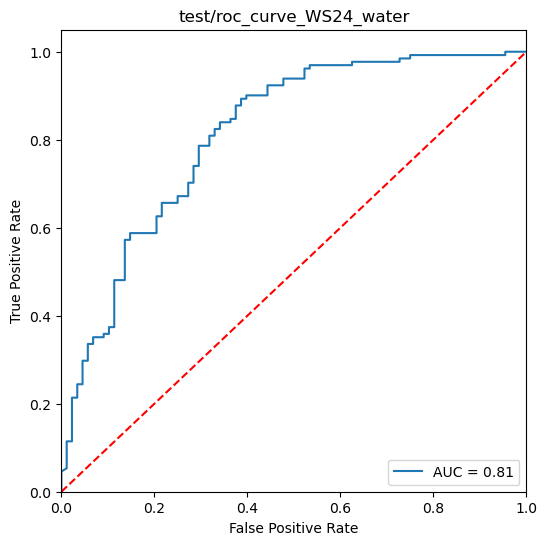

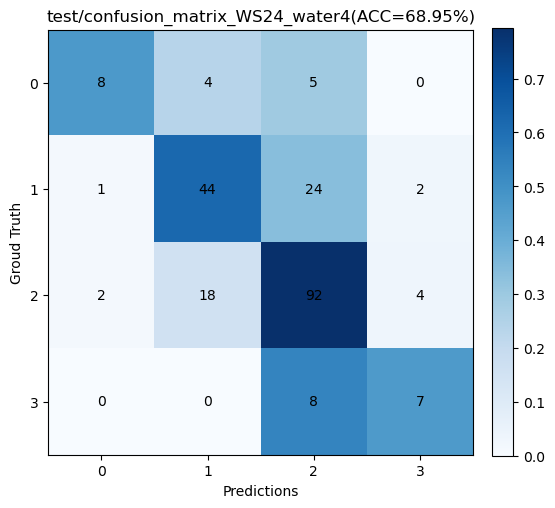

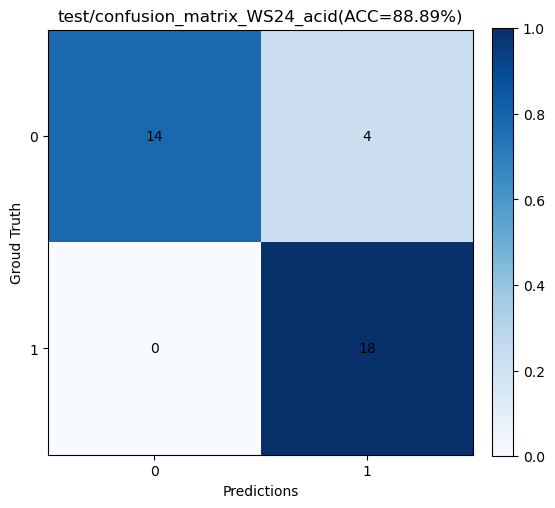

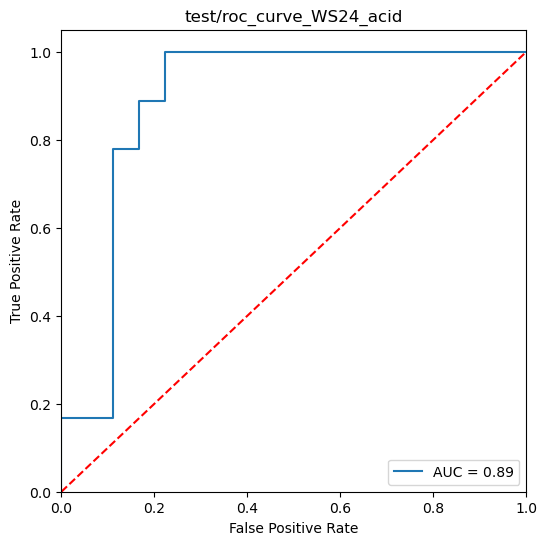

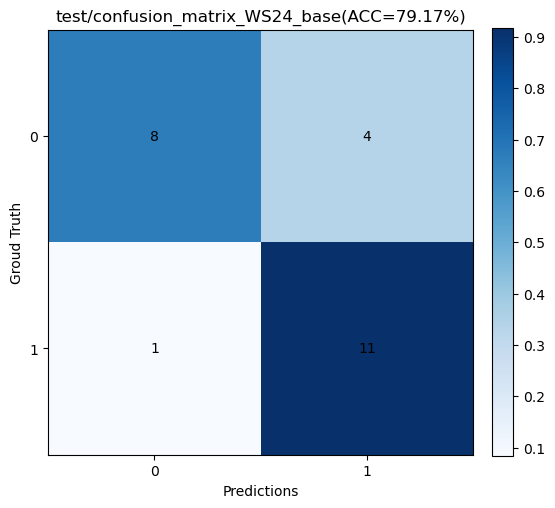

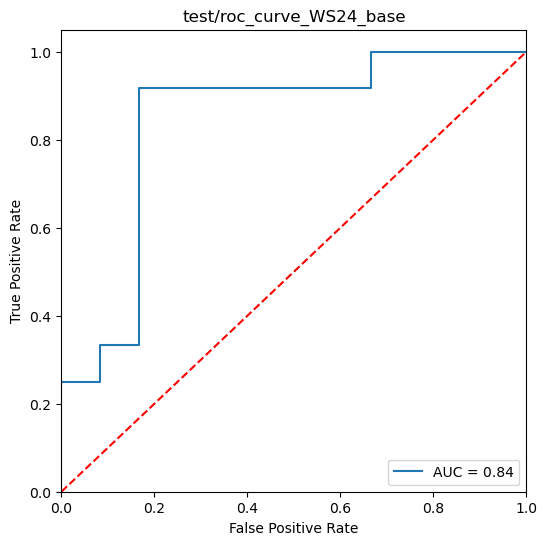

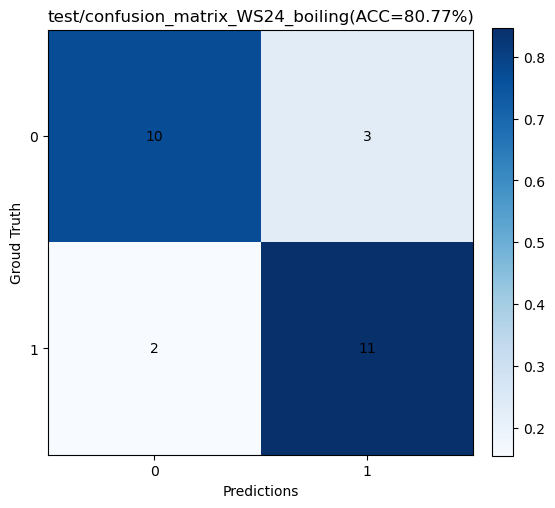

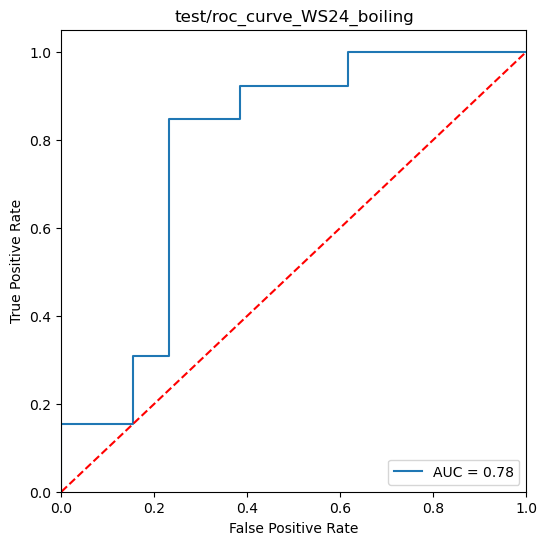

In [13]:
res = {}
result_dir = Path("./CGCNN_MT/evaluation")

data_dirs = [
    "./CGCNN_MT/data/TSD",
    "./CGCNN_MT/data/SSD", 
    "./CGCNN_MT/data/WS24",
]
col2tasks = [
    {"Label": "TSD"},
    {"Label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"},
    ]

tasks = [
    "TSD_SSD_WS24_water_WS24_water4", 
    "WS24_all",
    "TSD_SSD_WS24_all_attn"
]
metric_collections = []
for task in tasks:
    model_dir = task2models[task]["Path"]
    if task in ["TSD_SSD_WS24_all_attn"]:
        model_name = "MOFSNN_full"
    else:
        model_name = "MOFSNN_" + task
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        for split in ["test"]:
            all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
            if all_metrics:
                all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
                all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
                metric_collections.append(all_metrics)

In [14]:
metric_collections

[{'TSD/R2Score': 0.4486852810190125,
  'TSD/MeanAbsoluteError': 46.24155,
  'Model': 'MOFSNN_TSD_SSD_WS24_water_WS24_water4',
  'Version': 'version_13',
  'Split': 'test'},
 {'SSD/Accuracy': 0.7385321100917431,
  'SSD/BalancedAccuracy': 0.7259060638695356,
  'SSD/F1Score': 0.7263477801268499,
  'SSD/MatthewsCorrCoef': 0.45272848228272855,
  'SSD/AUROC': 0.7916547616431131,
  'Model': 'MOFSNN_TSD_SSD_WS24_water_WS24_water4',
  'Version': 'version_13',
  'Split': 'test'},
 {'WS24_water/Accuracy': 0.7488584474885844,
  'WS24_water/BalancedAccuracy': 0.737855655794587,
  'WS24_water/F1Score': 0.7382944052145572,
  'WS24_water/MatthewsCorrCoef': 0.47662176469309114,
  'WS24_water/AUROC': 0.8298056904927135,
  'WS24_water4/Accuracy': 0.6621004566210046,
  'WS24_water4/BalancedAccuracy': 0.6175277833328572,
  'WS24_water4/F1Score': 0.5897032579069121,
  'WS24_water4/MatthewsCorrCoef': 0.4562669555543503,
  'WS24_water4/AUROC': 0.8230641341853238,
  'Model': 'MOFSNN_TSD_SSD_WS24_water_WS24_wat

In [17]:
reversed_dict = {}
for metric_d in metric_collections:
    model = metric_d["Model"]
    version = metric_d["Version"]
    split = metric_d["Split"]
    for metric_name, metric_value in metric_d.items():
        if metric_name in ["Model", "Version", "Split"]:
            continue
        task_name, metric_name = metric_name.split("/")
        if (task_name, model, version, split) not in reversed_dict:
            reversed_dict[(task_name, model, version, split)] = {metric_name: metric_value}
        else:
            reversed_dict[(task_name, model, version, split)][metric_name] = metric_value
records = []
for k, v in reversed_dict.items():
    task_name, model, version, split = k
    v.update({"Model": model, "Version": version, "Split": split, "Task": task_name})
    records.append(v)
df_res = pd.DataFrame(records)
model_map = {
    "MOFSNN_TSD_SSD_WS24_water_WS24_water4": "MOFSNN_large",
    "MOFSNN_WS24_all": "MOFSNN_strong",
    "MOFSNN_full": "MOFSNN"
    
}
metric_name_map = {
    "R2Score": "R2",
    "MeanAbsoluteError": "MAE",
    "Accuracy": "ACC",
    "BalancedAccuracy": "BACC",
    "F1Score": "F1",
    "MatthewsCorrCoef": "MCC",
}
df_res["Model"] = df_res["Model"].map(model_map).copy()
df_res.rename(columns=metric_name_map, inplace=True)
for split in df_res["Split"].unique():
    print(f"Split: {split}")
    sub_df = df_res[df_res["Split"] == split].copy()
    sub_df.set_index(["Task", "Model"], inplace=True)
    sub_df.drop(columns=["Split", "Version", "F1", "MCC"], inplace=True)
    index = []
    for task in ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]:
        for model in ["MOFSNN_large", "MOFSNN_strong", "MOFSNN"]:
            index.append((task, model))
    sub_df = sub_df.reindex(index)
    sub_df.to_excel(saved_dir/f"MOFSNN_subset_model_results_{split}.xlsx")

Split: test


In [18]:
metric_items = []
for i, row in sub_df.iterrows():
    
    for col in row.index:
        if pd.isna(row[col]):
            continue
        record = list(row.name)
        record.append(col)
        record.append(row[col])
        metric_items.append(record)


metric_df = pd.DataFrame(metric_items, columns=['Task', 'Model', 'Metric', 'Value'])
metric_df

Task          Model Metric      Value
0            TSD   MOFSNN_large     R2   0.448685
1            TSD   MOFSNN_large    MAE  46.241550
2            TSD         MOFSNN     R2   0.448383
3            TSD         MOFSNN    MAE  45.197021
4            SSD   MOFSNN_large    ACC   0.738532
5            SSD   MOFSNN_large   BACC   0.725906
6            SSD   MOFSNN_large  AUROC   0.791655
7            SSD         MOFSNN    ACC   0.738532
8            SSD         MOFSNN   BACC   0.712060
9            SSD         MOFSNN  AUROC   0.769138
10    WS24_water   MOFSNN_large    ACC   0.748858
11    WS24_water   MOFSNN_large   BACC   0.737856
12    WS24_water   MOFSNN_large  AUROC   0.829806
13    WS24_water  MOFSNN_strong    ACC   0.748858
14    WS24_water  MOFSNN_strong   BACC   0.724800
15    WS24_water  MOFSNN_strong  AUROC   0.800139
16    WS24_water         MOFSNN    ACC   0.776256
17    WS24_water         MOFSNN   BACC   0.751431
18    WS24_water         MOFSNN  AUROC   0.812760
19   WS24_water4   MOFSNN_large    ACC   0.662100
20   WS24_water4   MOFSNN_large   BACC   0.617528
21   WS24_water4   MOFSNN_large  AUROC   0.823064
22   WS24_water4  MOFSNN_strong    ACC   0.639269
23   WS24_water4  MOFSNN_strong   BACC   0.601883
24   WS24_water4  MOFSNN_strong  AUROC   0.814047
25   WS24_water4         MOFSNN    ACC   0.689498
26   WS24_water4         MOFSNN   BACC   0.587519
27   WS24_water4         MOFSNN  AUROC   0.817405
28     WS24_acid  MOFSNN_strong    ACC   0.777778
29     WS24_acid  MOFSNN_strong   BACC   0.777778
30     WS24_acid  MOFSNN_strong  AUROC   0.808642
31     WS24_acid         MOFSNN    ACC   0.888889
32     WS24_acid         MOFSNN   BACC   0.888889
33     WS24_acid         MOFSNN  AUROC   0.888889
34     WS24_base  MOFSNN_strong    ACC   0.791667
35     WS24_base  MOFSNN_strong   BACC   0.791667
36     WS24_base  MOFSNN_strong  AUROC   0.875000
37     WS24_base         MOFSNN    ACC   0.791667
38     WS24_base         MOFSNN   BACC   0.791667
39     WS24_base         MOFSNN  AUROC   0.840278
40  WS24_boiling  MOFSNN_strong    ACC   0.692308
41  WS24_boiling  MOFSNN_strong   BACC   0.692308
42  WS24_boiling  MOFSNN_strong  AUROC   0.828402
43  WS24_boiling         MOFSNN    ACC   0.807692
44  WS24_boiling         MOFSNN   BACC   0.807692
45  WS24_boiling         MOFSNN  AUROC   0.775148

## MOFSNN component ablation study

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 19
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs0721
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: att_cgcnn
atom_fea_len: 32
extra_fea_len: 16
h_fea_len: 48
n_conv: 6
n_h: 10
att_S: 64
dropout_prob: 0.5
att_pooling: False
task_norm: True
dwa_temp:

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.3807, TSD/test_MeanAbsoluteError: 48.1063


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_3/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 19
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs0721
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: att_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_3/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 19
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs0721
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: False
use_extra_fea: False
augment: False
model_name: att_

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_3/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 10
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs0722
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_c

Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4185, TSD/test_MeanAbsoluteError: 47.2436


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_1/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 10
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs0722
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_c

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_1/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 10
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs0722
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_c

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/zhangsd/repos/MOFSNN/CGCNN_MT/module/module_utils.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_1/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn


Predicting: |          | 0/? [00:00<?, ?it/s]

(626,) (626,)
TSD/test_R2Score: 0.4484, TSD/test_MeanAbsoluteError: 45.1970


/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv
task_types:  ['regression', 'classification', 'classification', 'classification_4', 'classification', 'classification', 'classification']
Model hyperparameters:////////////////////////////////////////////////////////////
batch_size: 32
num_workers: 2
random_seed: 42
accelerator: gpu
devices: 1
max_epochs: 500
auto_lr_bs_find: False
progress_bar: False
focal_alpha: 0.25
focal_gamma: 2
optim: adam
lr: 0.001
weight_decay: 1e-05
momentum: 0.9
optim_config: fine
group_lr: True
lr_mult: 1
lr_scheduler: reduce_on_plateau
lr_decay_steps: 20
lr_decay_rate: 0.8
lr_decay_min_lr: 1e-06
max_steps: -1
decay_power: 1
warmup_steps: 2
load_best: False
log_dir: logs
patience: 50
min_delta: 0.001
monitor: val_Metric
mode: max
eval_freq: 10
max_num_nbr: 10
radius: 8
dmin: 0
step: 0.2
use_cell_params: True
use_extra_fea: False
augment: False
model_name: att_cgcnn

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_water4...
prop_cols: ['water4_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_acid...
prop_cols: ['acid_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_base...
prop_cols: ['base_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/share/miniconda3/envs/mofmthnn/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/share/miniconda3/envs/mofmthnn/lib/python3.9/si ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting WS24_boiling...
prop_cols: ['boiling_label']


Predicting: |          | 0/? [00:00<?, ?it/s]

Metrics saved to CGCNN_MT/evaluation/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn@version_43/test_metrics.csv


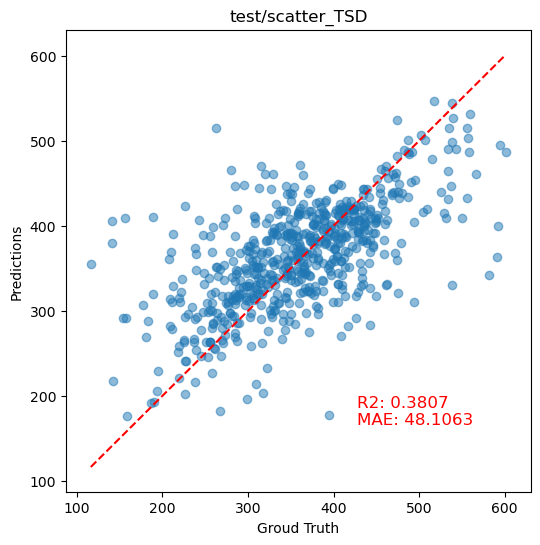

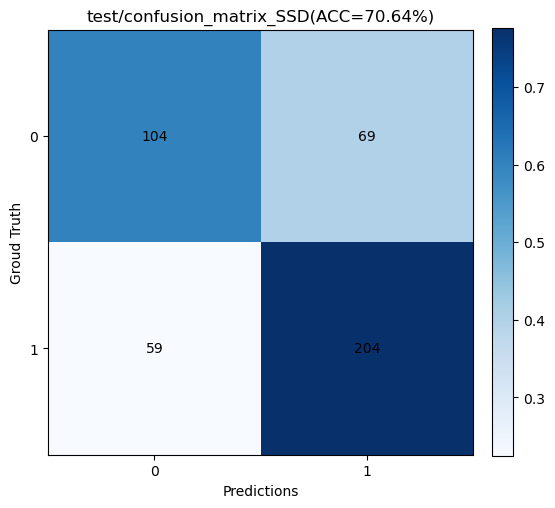

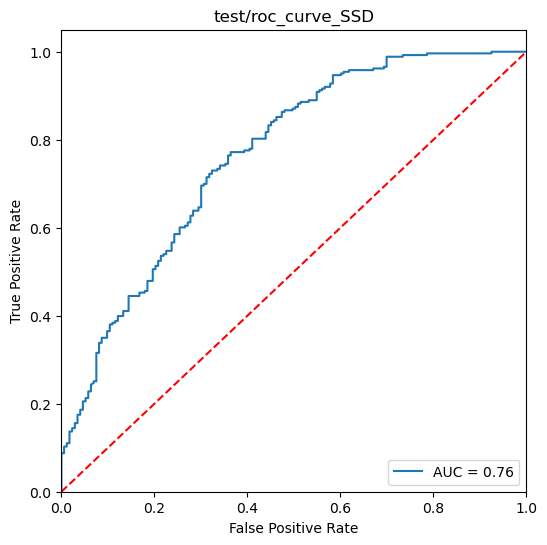

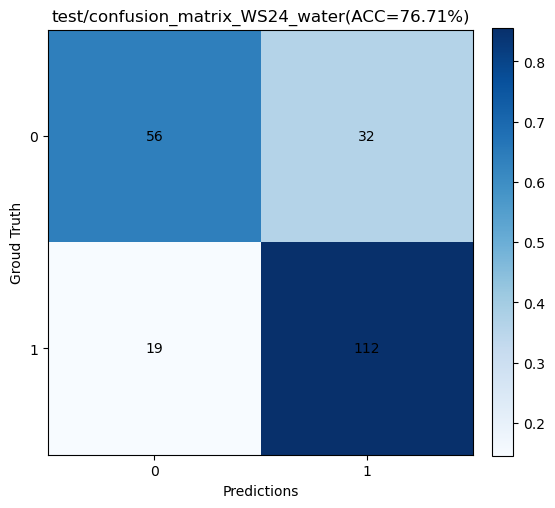

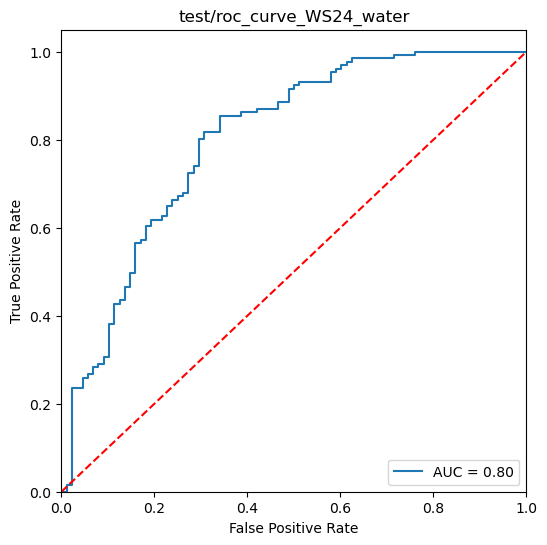

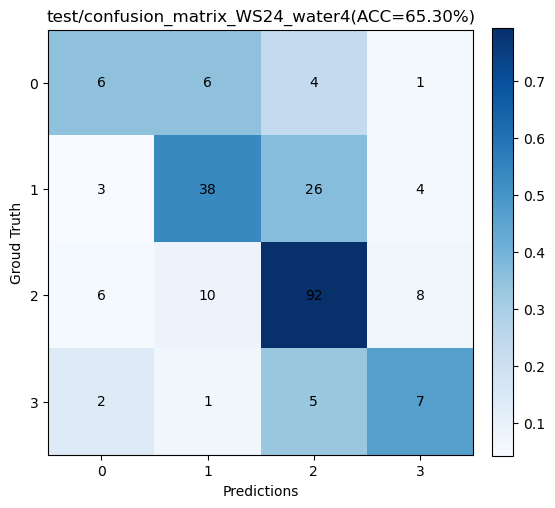

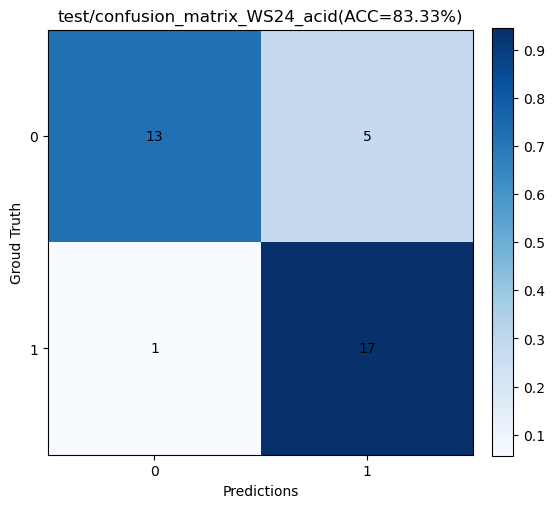

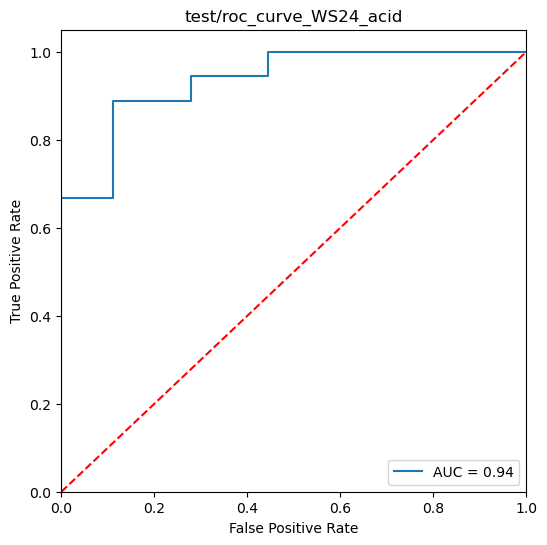

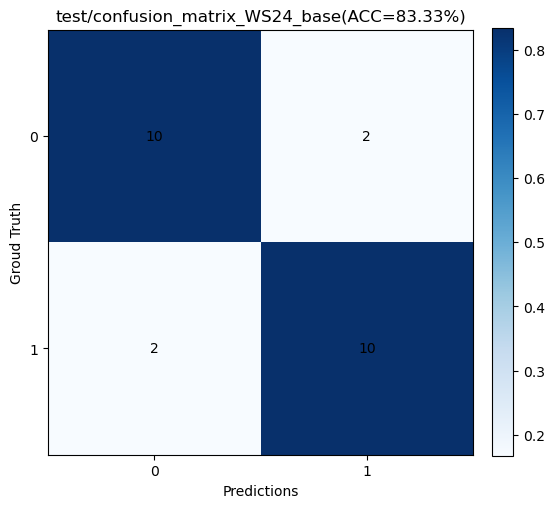

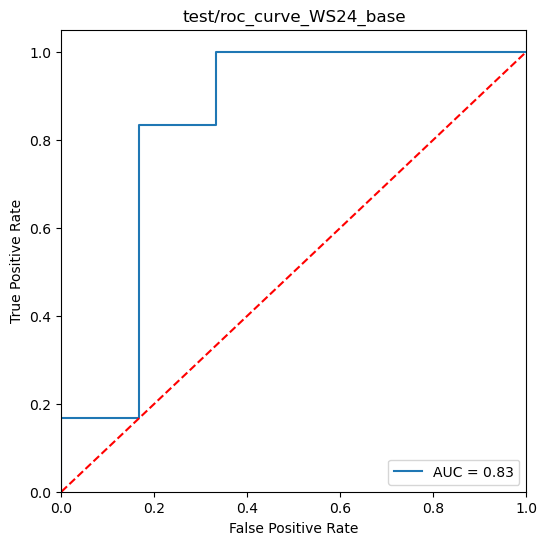

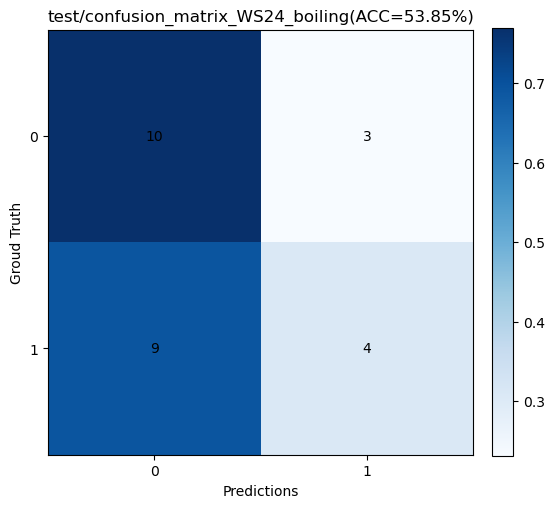

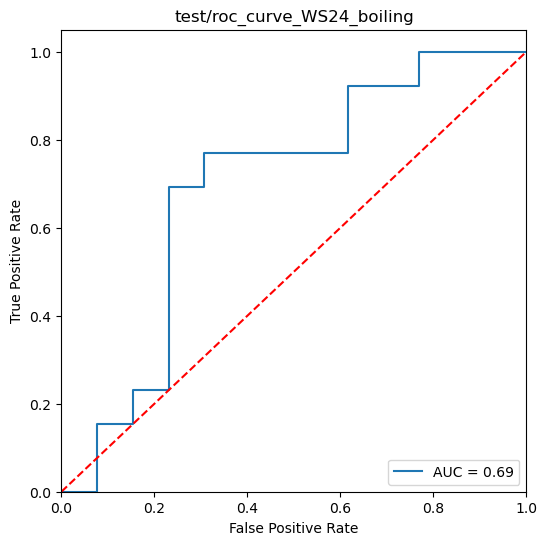

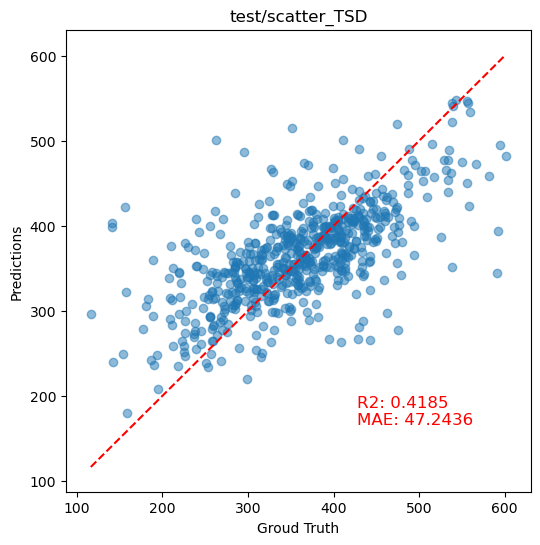

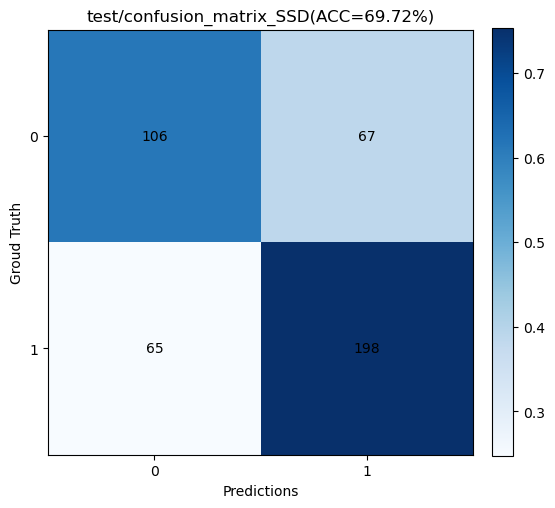

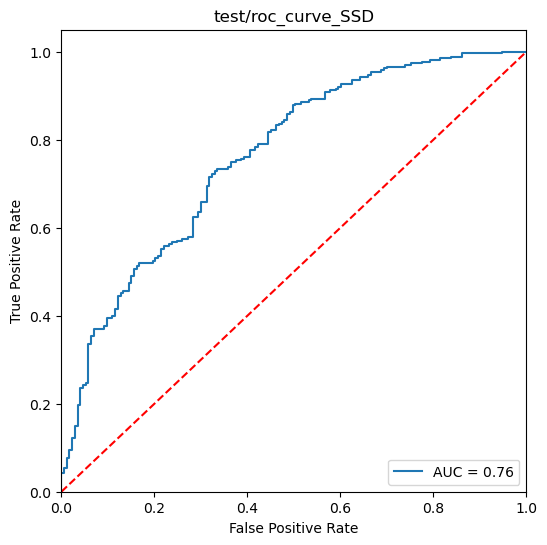

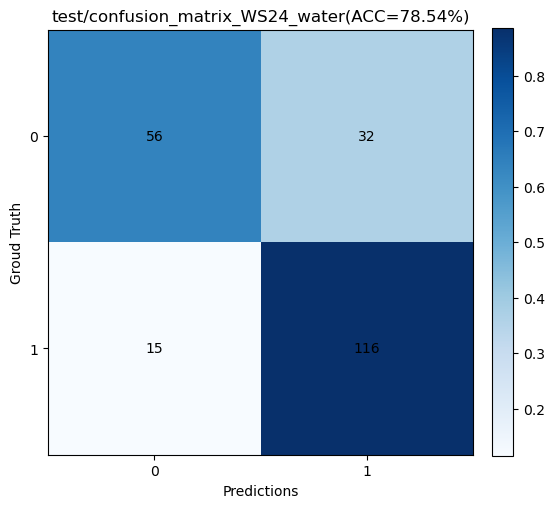

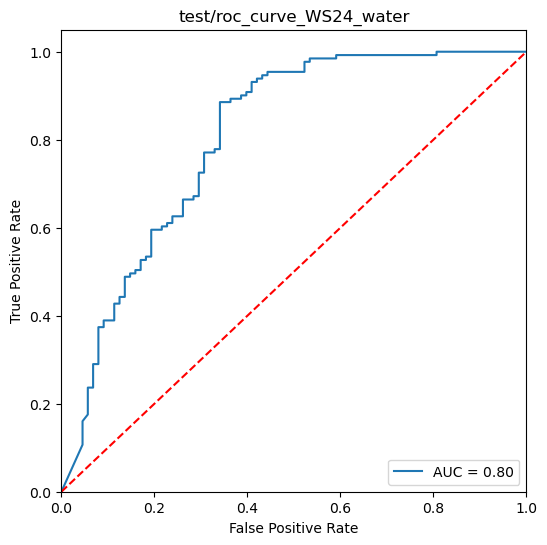

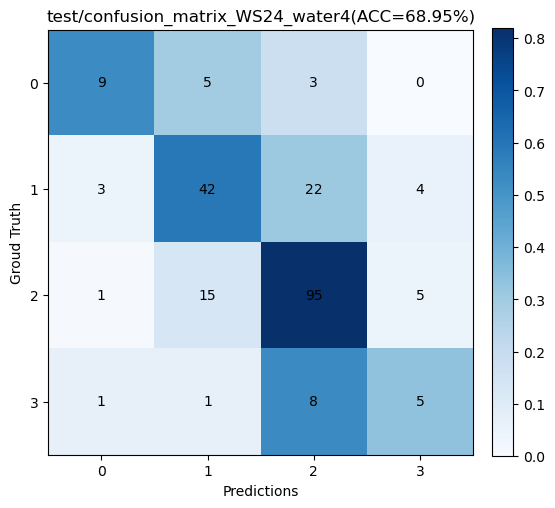

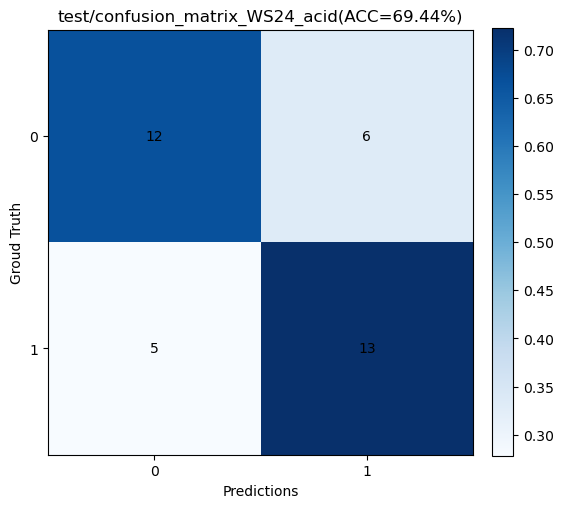

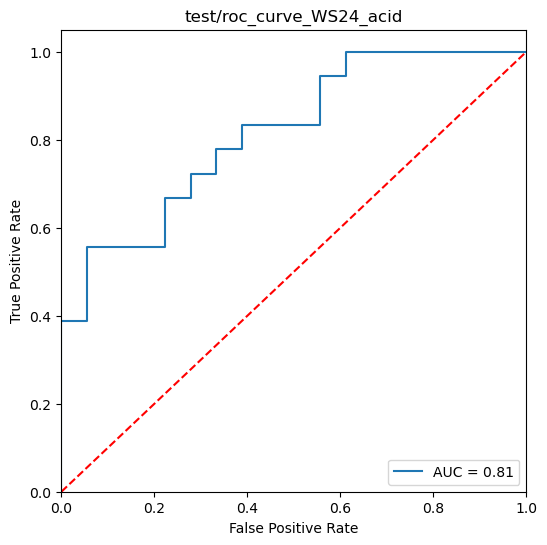

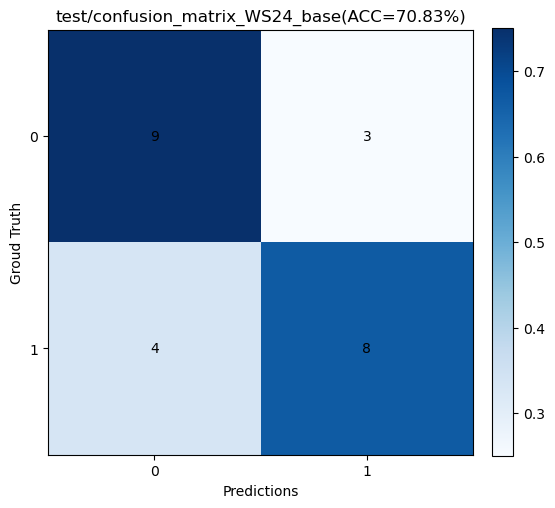

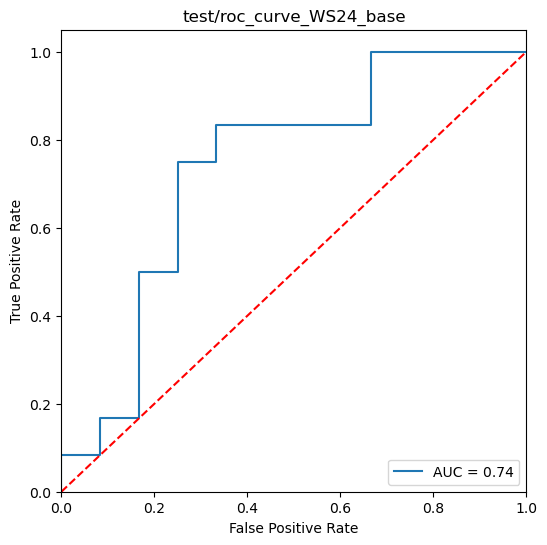

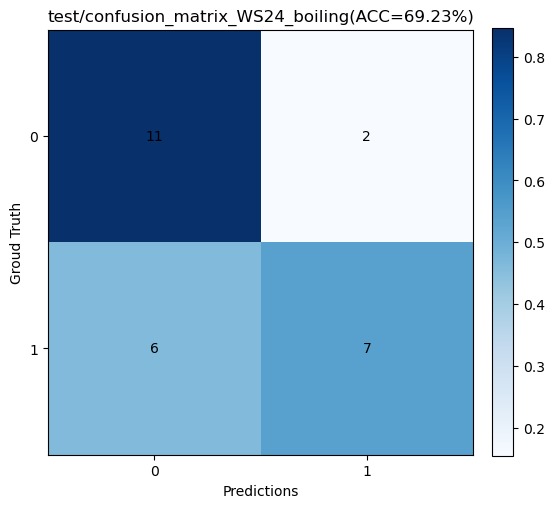

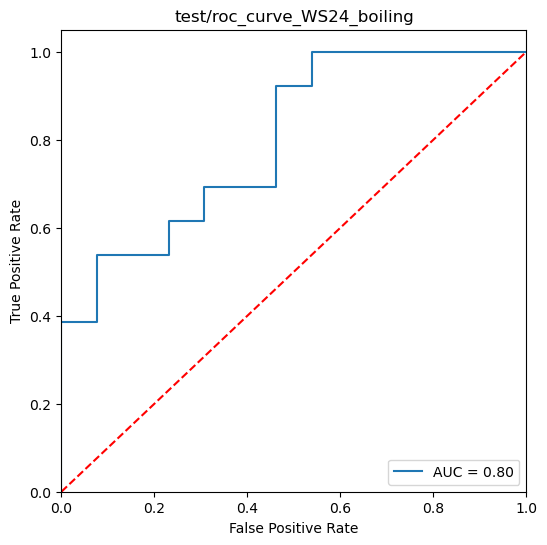

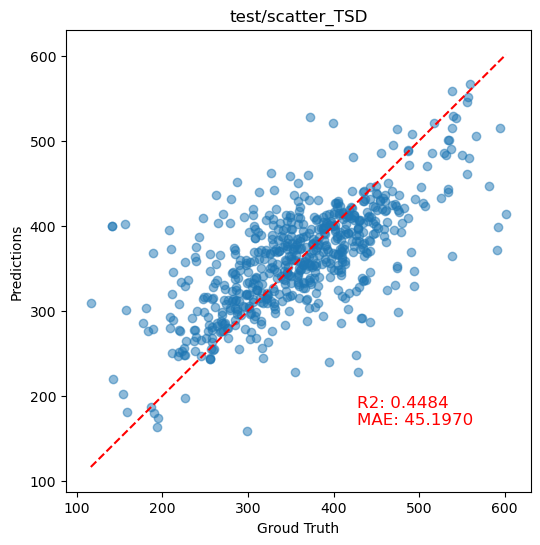

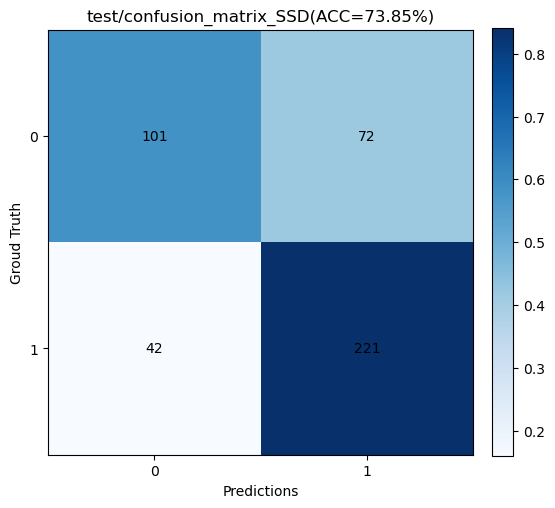

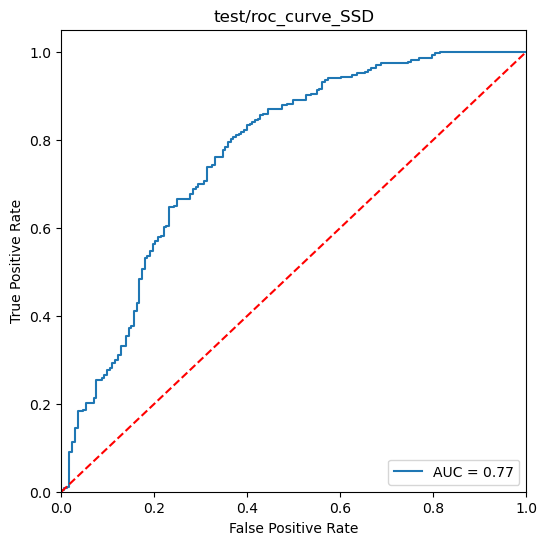

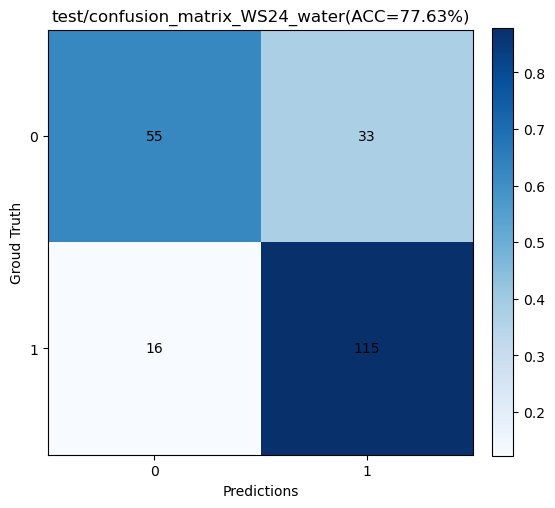

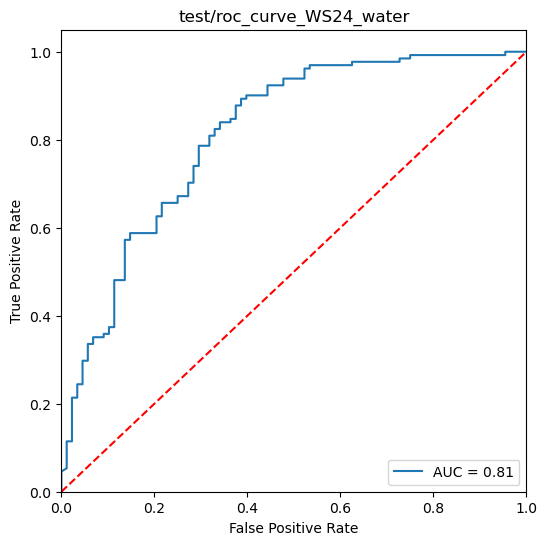

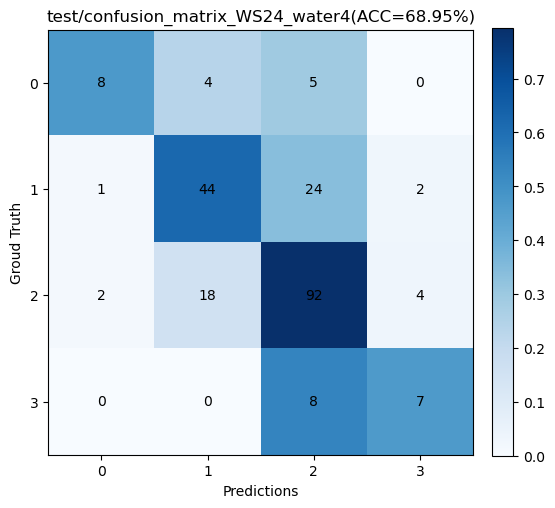

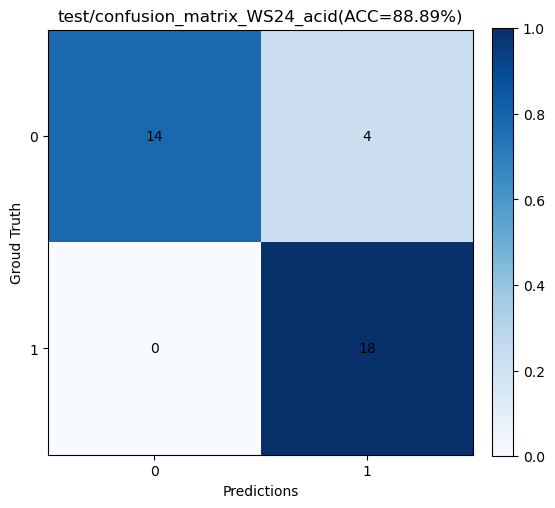

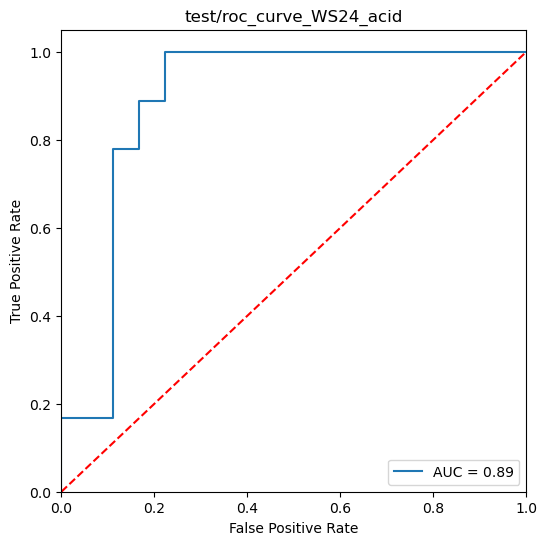

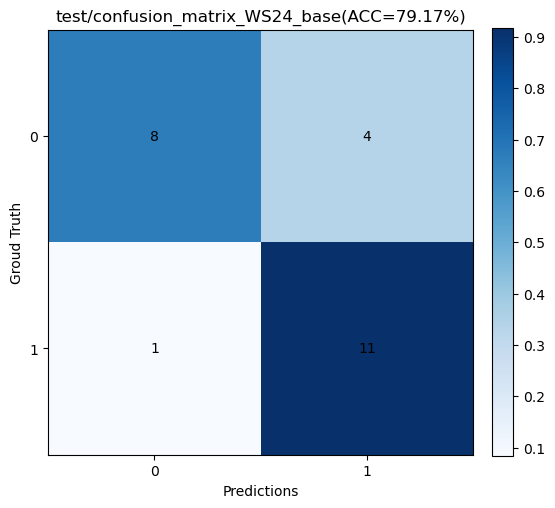

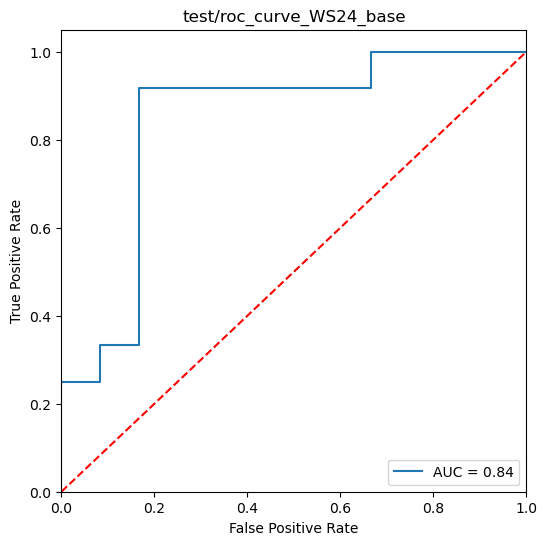

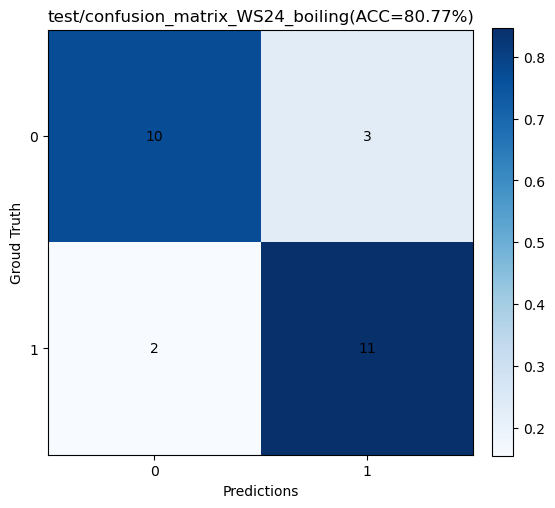

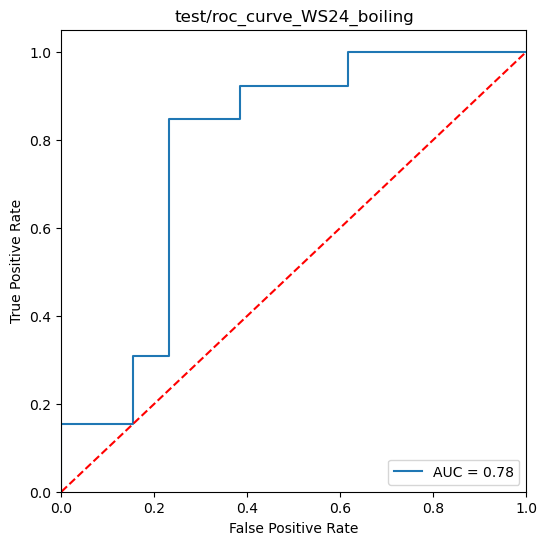

In [7]:
task2models = {'MOFSNN_no_lattice': {'Model': 'MOFSNN_no_lattice',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_3'},
 'MOFSNN_no_attn': {'Model': 'MOFSNN_no_attn',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_1'},
 'MOFSNN': {'Model': 'MOFSNN',
  'Path': './CGCNN_MT/logs/TSD_SSD_WS24_water_WS24_water4_WS24_acid_WS24_base_WS24_boiling_seed42_att_cgcnn/version_43'}
 }

res = {}
result_dir = Path("./CGCNN_MT/evaluation")

data_dirs = [
    "./CGCNN_MT/data/TSD",
    "./CGCNN_MT/data/SSD", 
    "./CGCNN_MT/data/WS24",
]
col2tasks = [
    {"Label": "TSD"},
    {"Label": "SSD"},
    {"water_label": "WS24_water", "water4_label": "WS24_water4", "acid_label": "WS24_acid", "base_label": "WS24_base", "boiling_label": "WS24_boiling"},
    ]

tasks = [
    "MOFSNN_no_lattice", 
    "MOFSNN_no_attn",
    "MOFSNN"
]
metric_collections = []
for task in tasks:
    model_dir = task2models[task]["Path"]
    model_name = task2models[task]["Model"]
    version_name = Path(model_dir).name
    for col2task, data_dir in zip(col2tasks, data_dirs):
        for split in ["test"]:
            all_outputs, all_metrics = predict_main(model_dir, data_dir, col2task, split=split, result_dir=result_dir)
            if all_metrics:
                all_metrics = {k.replace(f"{split}_", "") : v for k,v in all_metrics.items()}
                all_metrics.update({"Model": model_name, "Version": version_name, "Split": split})
                metric_collections.append(all_metrics)

In [8]:
metric_collections

[{'TSD/R2Score': 0.3806564563846472,
  'TSD/MeanAbsoluteError': 48.106323,
  'Model': 'MOFSNN_no_lattice',
  'Version': 'version_3',
  'Split': 'test'},
 {'SSD/Accuracy': 0.7064220183486238,
  'SSD/BalancedAccuracy': 0.6884107343018528,
  'SSD/F1Score': 0.6901208244491827,
  'SSD/MatthewsCorrCoef': 0.3810319891194151,
  'SSD/AUROC': 0.7649948350513198,
  'Model': 'MOFSNN_no_lattice',
  'Version': 'version_3',
  'Split': 'test'},
 {'WS24_water/Accuracy': 0.7671232876712328,
  'WS24_water/BalancedAccuracy': 0.7456627342123525,
  'WS24_water/F1Score': 0.7508310094813162,
  'WS24_water/MatthewsCorrCoef': 0.5076149252429452,
  'WS24_water/AUROC': 0.8009195003469813,
  'WS24_water4/Accuracy': 0.6529680365296804,
  'WS24_water4/BalancedAccuracy': 0.5369806397546877,
  'WS24_water4/F1Score': 0.5283293564339315,
  'WS24_water4/MatthewsCorrCoef': 0.4237851397142549,
  'WS24_water4/AUROC': 0.7896813209661394,
  'WS24_acid/Accuracy': 0.8333333333333334,
  'WS24_acid/BalancedAccuracy': 0.8333333333

In [15]:
reversed_dict = {}
for metric_d in metric_collections:
    model = metric_d["Model"]
    version = metric_d["Version"]
    split = metric_d["Split"]
    for metric_name, metric_value in metric_d.items():
        if metric_name in ["Model", "Version", "Split"]:
            continue
        task_name, metric_name = metric_name.split("/")
        if (task_name, model, version, split) not in reversed_dict:
            reversed_dict[(task_name, model, version, split)] = {metric_name: metric_value}
        else:
            reversed_dict[(task_name, model, version, split)][metric_name] = metric_value
records = []
for k, v in reversed_dict.items():
    task_name, model, version, split = k
    v.update({"Model": model, "Version": version, "Split": split, "Task": task_name})
    records.append(v)
df_res = pd.DataFrame(records)

metric_name_map = {
    "R2Score": "R2",
    "MeanAbsoluteError": "MAE",
    "Accuracy": "ACC",
    "BalancedAccuracy": "BACC",
    "F1Score": "F1",
    "MatthewsCorrCoef": "MCC",
}

df_res.rename(columns=metric_name_map, inplace=True)
for split in df_res["Split"].unique():
    print(f"Split: {split}")
    sub_df = df_res[df_res["Split"] == split].copy()
    sub_df.set_index(["Task", "Model"], inplace=True)
    sub_df.drop(columns=["Split", "Version", "F1", "MCC"], inplace=True)
    index = []
    for task in ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]:
        for model in ["MOFSNN_no_lattice", "MOFSNN_no_attn", "MOFSNN"]:
            index.append((task, model))
    sub_df_ = sub_df.reindex(index)
    sub_df_.to_excel(saved_dir/f"MOFSNN_ablation_model_results_{split}.xlsx")

    # index = []
    # for task in ["TSD", "SSD", "WS24_water", "WS24_water4", "WS24_acid", "WS24_base", "WS24_boiling"]:
    #     for model in ["MOFSNN_no_attn", "MOFSNN"]:
    #         index.append((task, model))
    # sub_df_ = sub_df.reindex(index)
    # sub_df_.to_excel(saved_dir/f"MOFSNN_ablation_attn_model_results_{split}.xlsx")

Split: test
